# Data Loading and Preprocessing

This section involves loading the data, preprocessing it, and preparing it for analysis.


In [6]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# Load data
file_path = 'data/all_data_floris.parquet.gzip'
df = pd.read_parquet(file_path)

# Data filtering and cleaning
df = df[df['confidence'] >= 0.9]
df = df.dropna(subset=['first_supplying_date'])
df = df[df['language'].isin(['en', 'en-US'])]
df = df[df['call_time_seconds'] > 60]
df['supply_28d_before'] = df['supply_28d_before'].fillna(0).astype(int)
df['supply_28d_after'] = df['supply_28d_after'].fillna(0).astype(int)
df['supply_diff'] = (df['supply_28d_after'] - df['supply_28d_before']).astype(int)
df = df[df['store_category'] != 'Key Account']

# Create supply difference buckets
non_positive = df[df['supply_diff'] <= 0].copy()
positive = df[df['supply_diff'] > 0].copy()
num_buckets = 3
bucket_labels = pd.qcut(positive['supply_diff'], q=num_buckets, labels=False)

# Recode labels into a single column with ordinal encoding
non_positive.loc[:, 'impact'] = 0  # Non-positive impact
positive.loc[:, 'impact'] = bucket_labels + 1  # Offset by 1

# Combine back into a single DataFrame
df = pd.concat([non_positive, positive])
df.set_index('aircall_id', inplace=True)
df = df[['transcripts', 'impact']]

# Download NLTK stopwords
nltk.download('stopwords')

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[\d\W]+', ' ', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Function to split transcripts into agent and external
def split_transcripts(df):
    df['clean_agent'] = ''
    df['clean_external'] = ''

    for index, row in df.iterrows():
        parts = re.split(r'(AGENT:|EXTERNAL:)', row['transcripts'])
        agent_text = []
        external_text = []
        current_speaker = None

        for part in parts:
            if 'AGENT:' in part:
                current_speaker = 'agent'
            elif 'EXTERNAL:' in part:
                current_speaker = 'external'
            else:
                if current_speaker == 'agent':
                    agent_text.append(part)
                elif current_speaker == 'external':
                    external_text.append(part)

        agent_text = preprocess_text(' '.join(agent_text))
        external_text = preprocess_text(' '.join(external_text))
        df.at[index, 'clean_agent'] = agent_text
        df.at[index, 'clean_external'] = external_text

    return df

# Split and preprocess the transcripts
df = split_transcripts(df)

# Save the DataFrame to a pickle file
output_file_path = 'data/data_postprocessing.pkl'
df.to_pickle(output_file_path)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Visualization: Impact Column

This section includes visualizing the distribution of the 'impact' column.


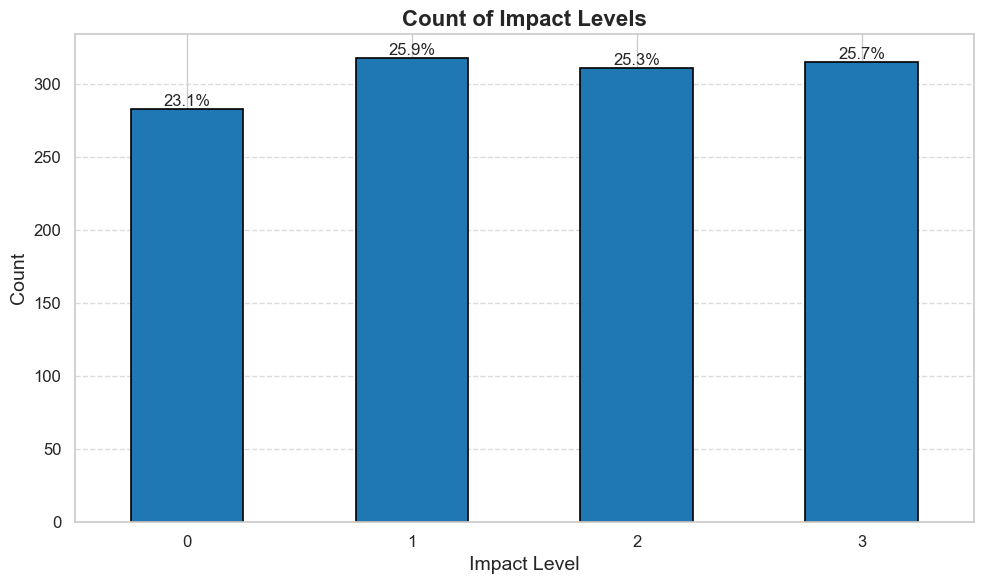

In [54]:
import matplotlib.pyplot as plt

# Plotting the impact levels
impact_counts = df['impact'].value_counts().sort_index()
total_count = impact_counts.sum()

plt.figure(figsize=(10, 6))
bars = impact_counts.plot(kind='bar', color='#1f77b4', edgecolor='black', linewidth=1.2)
plt.title('Count of Impact Levels', fontsize=16, weight='bold')
plt.xlabel('Impact Level', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars.patches:
    height = bar.get_height()
    percentage = f'{(height / total_count) * 100:.1f}%'
    plt.text(bar.get_x() + bar.get_width() / 2, height, percentage, ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


# Baseline Model

Building a baseline model using TF-IDF and Linear Regression for initial analysis.


Baseline metrics saved successfully.


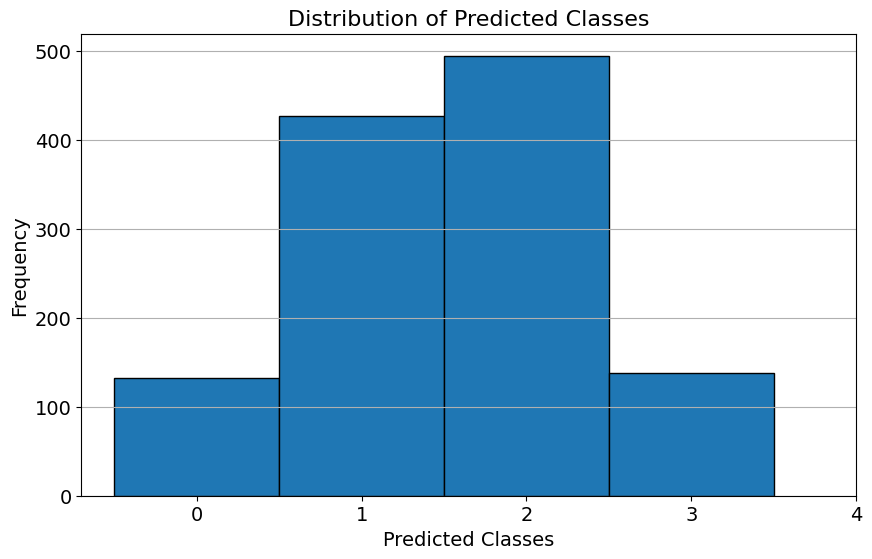

In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, cohen_kappa_score, confusion_matrix
from scipy.stats import spearmanr
from sklearn.model_selection import StratifiedKFold
import json
import os

# Assuming df is already loaded and preprocessed

# Concatenate agent and external columns
df['clean_text'] = df['clean_agent'] + ' ' + df['clean_external']

# Initialize k-fold cross-validation
kf = StratifiedKFold(n_splits=5)

# Placeholder for metrics
metrics_base = []
all_predicted_classes = []  # List to store all predicted classes

for train_index, val_index in kf.split(df['clean_text'], df['impact']):
    X_train, X_val = df['clean_text'].iloc[train_index], df['clean_text'].iloc[val_index]
    y_train, y_val = df['impact'].iloc[train_index], df['impact'].iloc[val_index]

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=8897)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)

    # Linear Regression
    model = LinearRegression()
    model.fit(X_train_tfidf, y_train)

    # Predictions
    y_pred = model.predict(X_val_tfidf)
    y_pred_classes = np.round(y_pred).astype(int)

    # Ensure predicted classes are within the valid range
    y_pred_classes = np.clip(y_pred_classes, 0, 3)

    # Store the predicted classes
    all_predicted_classes.extend(y_pred_classes)

    # Performance Metrics on Actual Predictions
    mae = mean_absolute_error(y_val, y_pred_classes)
    mse = mean_squared_error(y_val, y_pred_classes)
    rmse = np.sqrt(mse)
    spearman_corr, _ = spearmanr(y_val, y_pred_classes)
    qwk = cohen_kappa_score(y_val, y_pred_classes, weights='quadratic')
    accuracy = accuracy_score(y_val, y_pred_classes)
    conf_matrix = confusion_matrix(y_val, y_pred_classes).tolist()

    metrics_entry = {
        'embedding': 'tfidf',
        'rnn_layer': 'linear_regression',
        'fold': len(metrics_base) + 1,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'spearman_corr': spearman_corr,
        'qwk': qwk,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'val_predictions': y_pred_classes.tolist(),
        'val_true': y_val.tolist(),  # Save true values for post hoc analysis
        'training_time': 'N/A',  # Not applicable for baseline linear regression
        'early_stopping_epoch': 'N/A'  # Not applicable for baseline linear regression
    }

    metrics_base.append(metrics_entry)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics_base)

# Save metrics to a JSON file
metrics_folder = 'saved_models/ord_regr/metrics'
os.makedirs(metrics_folder, exist_ok=True)
recalculated_metrics_file = os.path.join(metrics_folder, 'baseline_metrics2.json')
with open(recalculated_metrics_file, 'w') as f:
    json.dump(metrics_base, f, indent=4)

print("Baseline metrics saved successfully.")

# Plot the distribution of predicted classes
plt.figure(figsize=(10, 6))
plt.hist(all_predicted_classes, bins=range(5), align='left', edgecolor='black')
plt.xlabel('Predicted Classes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Predicted Classes', fontsize=16)
plt.xticks(range(5))
plt.grid(axis='y')
plt.show()


# Load Word Embeddings

Loading various word embeddings such as GloVe, Word2Vec, and FastText.


In [7]:
import gensim
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

# Embedding loading functions
def load_glove_embeddings(file_path, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

def load_word2vec_embeddings(file_path, word_index, embedding_dim=300, binary=False):
    model = gensim.models.KeyedVectors.load_word2vec_format(file_path, binary=binary)
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in model:
            embedding_matrix[i] = model[word]
    
    return embedding_matrix

def load_fasttext_embeddings(file_path, word_index, embedding_dim=300):
    model = gensim.models.fasttext.load_facebook_vectors(file_path)
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in model:
            embedding_matrix[i] = model[word]
    
    return embedding_matrix

# Tokenize and pad sequences
X_agent_texts = df['clean_agent'].tolist()
X_external_texts = df['clean_external'].tolist()
y = df['impact'].astype(int).values

# Combine the agent and external texts
combined_texts = X_agent_texts + X_external_texts

# Tokenize the texts
tokenizer = Tokenizer(num_words=8897)
tokenizer.fit_on_texts(combined_texts)
word_index = tokenizer.word_index

# Convert texts to sequences
X_agent_sequences = tokenizer.texts_to_sequences(X_agent_texts)
X_external_sequences = tokenizer.texts_to_sequences(X_external_texts)

# Pad the sequences
maxlen = 500
X_agent = pad_sequences(X_agent_sequences, maxlen=maxlen)
X_external = pad_sequences(X_external_sequences, maxlen=maxlen)

# Debugging: Print shapes of the data to ensure they are correct
print(f'X_agent shape: {X_agent.shape}')
print(f'X_external shape: {X_external.shape}')
print(f'y shape: {y.shape}')
print(f'Word index length: {len(tokenizer.word_index)}')

# Load the embeddings
glove_path = 'non-code/embedding/glove_100d/glove.6B.100d.txt'
word2vec_path = 'non-code/embedding/GoogleNews-vectors-negative300.bin/GoogleNews-vectors-negative300.bin'
fasttext_path = 'non-code/embedding/wiki-news-300d-1M-subword.bin/wiki-news-300d-1M-subword.bin'

try:
    glove_matrix = load_glove_embeddings(glove_path, word_index)
    print("GloVe embeddings loaded successfully.")
except Exception as e:
    print(f"Error loading GloVe embeddings: {e}")

try:
    word2vec_matrix = load_word2vec_embeddings(word2vec_path, word_index, binary=True)
    print("Word2Vec embeddings loaded successfully.")
except Exception as e:
    print(f"Error loading Word2Vec embeddings: {e}")

try:
    fasttext_matrix = load_fasttext_embeddings(fasttext_path, word_index)
    print("FastText embeddings loaded successfully.")
except Exception as e:
    print(f"Error loading FastText embeddings: {e}")

# Save the loaded models for debugging purposes
embedding_models = {
    'glove': glove_matrix,
    'word2vec': word2vec_matrix,
    'fasttext': fasttext_matrix
}


X_agent shape: (1227, 500)
X_external shape: (1227, 500)
y shape: (1227,)
Word index length: 8897
FastText embeddings loaded successfully.


# Build and Train RNN Models

Building and training RNN models using different types of embeddings.


In [ ]:
import numpy as np
import pandas as pd
import json
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, cohen_kappa_score, accuracy_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, Bidirectional, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.model_selection import StratifiedKFold
from scipy.stats import spearmanr

def build_ordinal_rnn_model(input_length=500, embedding_matrix=None, rnn_layer='gru'):
    agent_input = Input(shape=(input_length,), name='agent_input')
    external_input = Input(shape=(input_length,), name='external_input')
    embedding_layer = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],
                                weights=[embedding_matrix], trainable=False)
    
    if rnn_layer == 'simplernn':
        agent_rnn = SimpleRNN(16)(embedding_layer(agent_input))
        external_rnn = SimpleRNN(16)(embedding_layer(external_input))
    elif rnn_layer == 'gru':
        agent_rnn = GRU(16)(embedding_layer(agent_input))
        external_rnn = GRU(16)(embedding_layer(external_input))
    elif rnn_layer == 'lstm':
        agent_rnn = LSTM(16)(embedding_layer(agent_input))
        external_rnn = LSTM(16)(embedding_layer(external_input))
    elif rnn_layer == 'bi-lstm':
        agent_rnn = Bidirectional(LSTM(16))(embedding_layer(agent_input))
        external_rnn = Bidirectional(LSTM(16))(embedding_layer(external_input))
    
    agent_dense = Dense(8, activation='relu')(agent_rnn)
    external_dense = Dense(8, activation='relu')(external_rnn)
    
    concatenated = Concatenate()([agent_dense, external_dense])
    dense_layer = Dense(8, activation='relu')(concatenated)
    
    # Adjust output layer for ordinal regression (e.g., cumulative logit model)
    output = Dense(1)(dense_layer)  # Single output for ordinal regression

    model = Model(inputs=[agent_input, external_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.01), loss=MeanSquaredError(), metrics=['mae'])
    return model

def decay_schedule(epoch, lr):
    return lr * 0.9 if epoch > 0 else lr

lr_scheduler = LearningRateScheduler(decay_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.005)

kf = StratifiedKFold(n_splits=5)
rnn_layers = ['simplernn', 'gru', 'lstm', 'bi-lstm']

# Create folders to save metrics and models
models_dir = 'saved_models/ord_regr/latest_models'
metrics_folder = 'saved_models/ord_regr/metrics'
os.makedirs(models_dir, exist_ok=True)
os.makedirs(metrics_folder, exist_ok=True)

# Placeholder for metrics
metrics = []

for embedding_name, embedding_matrix in embedding_models.items():
    for rnn_layer in rnn_layers:
        fold = 0
        fold_metrics = []
        for train_index, val_index in kf.split(X_agent, y):
            fold += 1
            X_agent_train, X_agent_val = X_agent[train_index], X_agent[val_index]
            X_external_train, X_external_val = X_external[train_index], X_external[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = build_ordinal_rnn_model(embedding_matrix=embedding_matrix, rnn_layer=rnn_layer)

            history = model.fit(
                [X_agent_train, X_external_train], y_train,
                validation_data=([X_agent_val, X_external_val], y_val),
                epochs=100,
                callbacks=[lr_scheduler, early_stopping],
                verbose=0
            )

            val_predictions = model.predict([X_agent_val, X_external_val]).flatten()
            val_pred_classes = np.round(val_predictions).astype(int)

            mae = mean_absolute_error(y_val, val_pred_classes)
            mse = mean_squared_error(y_val, val_pred_classes)
            rmse = np.sqrt(mse)
            spearman_corr, _ = spearmanr(y_val, val_pred_classes)
            qwk = cohen_kappa_score(y_val, val_pred_classes, weights='quadratic')
            accuracy = accuracy_score(y_val, val_pred_classes)
            conf_matrix = confusion_matrix(y_val, val_pred_classes).tolist()

            metrics_entry = {
                'embedding': embedding_name,
                'rnn_layer': rnn_layer,
                'fold': fold,
                'mae': mae,
                'mse': mse,
                'rmse': rmse,
                'spearman_corr': spearman_corr,
                'qwk': qwk,
                'accuracy': accuracy,
                'confusion_matrix': conf_matrix,
                'val_predictions': val_predictions.tolist(),
                'val_true': y_val.tolist(),  # Save true values for post hoc analysis
                'training_time': history.history.get('time', 'N/A'),
                'early_stopping_epoch': early_stopping.stopped_epoch
            }
            fold_metrics.append(metrics_entry)
            metrics.append(metrics_entry)

            # Save the model
            model_name = f"{embedding_name}_{rnn_layer}_fold_{fold}.keras"
            model.save(os.path.join(models_dir, model_name))

        # Save metrics for each embedding-rnn combination
        metrics_df = pd.DataFrame(fold_metrics)
        metrics_df.to_csv(os.path.join(metrics_folder, f"{embedding_name}_{rnn_layer}_metrics.csv"), index=False)

# Save all metrics to a JSON file for later visualization
with open(os.path.join(metrics_folder, 'all_metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=4)

print("Models trained and saved successfully.")


# Model Evaluation and Visualization

Evaluating the model performance and visualizing the results.


In [56]:
import pandas as pd

# Load baseline and improved model metrics
metrics_folder = "saved_models/ord_regr/metrics"
baseline_metrics = pd.read_json(f'{metrics_folder}/baseline_metrics2.json')
all_metrics = pd.read_json(f'{metrics_folder}/all_metrics.json')

# Filter for GloVe-100 embeddings
glove_metrics = all_metrics[all_metrics['embedding'] == 'glove']

# Select relevant columns
relevant_columns = ['rnn_layer', 'accuracy', 'spearman_corr', 'qwk', 'mae', 'mse', 'rmse']
baseline_relevant = baseline_metrics[relevant_columns]
glove_relevant = glove_metrics[relevant_columns]

# Aggregate metrics by taking the mean for each model
baseline_agg = baseline_relevant.groupby('rnn_layer').mean().reset_index()
glove_agg = glove_relevant.groupby('rnn_layer').mean().reset_index()

# Combine baseline and GloVe results
combined_df = pd.concat([baseline_agg, glove_agg])

# Capitalize model names
combined_df['rnn_layer'] = combined_df['rnn_layer'].replace({
    'linear_regression': 'Baseline',
    'simplernn': 'SimpleRNN',
    'gru': 'GRU',
    'lstm': 'LSTM',
    'bi-lstm': 'Bi-LSTM'
})

# Rename the columns for better readability
combined_df = combined_df.rename(columns={
    'rnn_layer': 'Model Type',
    'accuracy': 'Accuracy',
    'spearman_corr': "Spearman's Rank Correlation",
    'qwk': "Cohen's Kappa"
})

# Reorder the columns
# combined_df = combined_df[['Model Type', 'Accuracy', "Spearman's Rank Correlation", "Cohen's Kappa"]]

# Print the comparison table
combined_df


Model Type  Accuracy  Spearman's Rank Correlation  Cohen's Kappa       mae  \
0   Baseline  0.331677                     0.231723       0.222235  0.921792   
0    Bi-LSTM  0.255895                     0.066208       0.042221  0.965771   
1        GRU  0.251837                     0.069246       0.046346  0.969049   
2       LSTM  0.254262                     0.000201       0.001902  0.986149   
3  SimpleRNN  0.246122                     0.047787       0.027048  0.978016   

        mse      rmse  
0  1.489039  1.217909  
0  1.409102  1.186994  
1  1.410821  1.187330  
2  1.466972  1.211076  
3  1.426292  1.193944

# confusion matrices


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Load baseline and improved model metrics
metrics_folder = "saved_models/ord_regr/metrics"
baseline_metrics = pd.read_json(f'{metrics_folder}/baseline_metrics2.json')
all_metrics = pd.read_json(f'{metrics_folder}/all_metrics_question_1_and_2.json.json')

# Ensure we are working on a copy
all_metrics = all_metrics.copy()

# Capitalize model names using .loc
all_metrics.loc[:, 'rnn_layer'] = all_metrics['rnn_layer'].replace({
    'simplernn': 'SimpleRNN',
    'gru': 'GRU',
    'lstm': 'LSTM',
    'bi-lstm': 'Bi-LSTM'
})

# Define baseline model name
baseline_metrics['rnn_layer'] = 'Baseline'

# Combine the baseline and all metrics
combined_metrics = pd.concat([baseline_metrics, all_metrics])

# Ensure the output directory exists
output_dir = 'visuali/confusion_matrices'
os.makedirs(output_dir, exist_ok=True)

# Function to plot and save the confusion matrix with higher DPI
def plot_confusion_matrix(y_true, y_pred, model_name, embedding_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name} with {embedding_name}')
    plt.savefig(os.path.join(output_dir, f'{model_name}_{embedding_name}_confusion_matrix.png'), dpi=300)  # Higher DPI
    plt.close()

# Iterate through each unique combination of embedding and model and plot the aggregate confusion matrix
for embedding in combined_metrics['embedding'].unique():
    for model in combined_metrics['rnn_layer'].unique():
        model_data = combined_metrics[(combined_metrics['embedding'] == embedding) & (combined_metrics['rnn_layer'] == model)]
        if not model_data.empty:
            y_true = np.concatenate(model_data['val_true'].values)
            y_pred = np.concatenate(model_data['val_predictions'].values)
            y_pred = np.round(y_pred).astype(int)  # Round predictions to nearest integer
            plot_confusion_matrix(y_true, y_pred, model, embedding)



# visualization of results

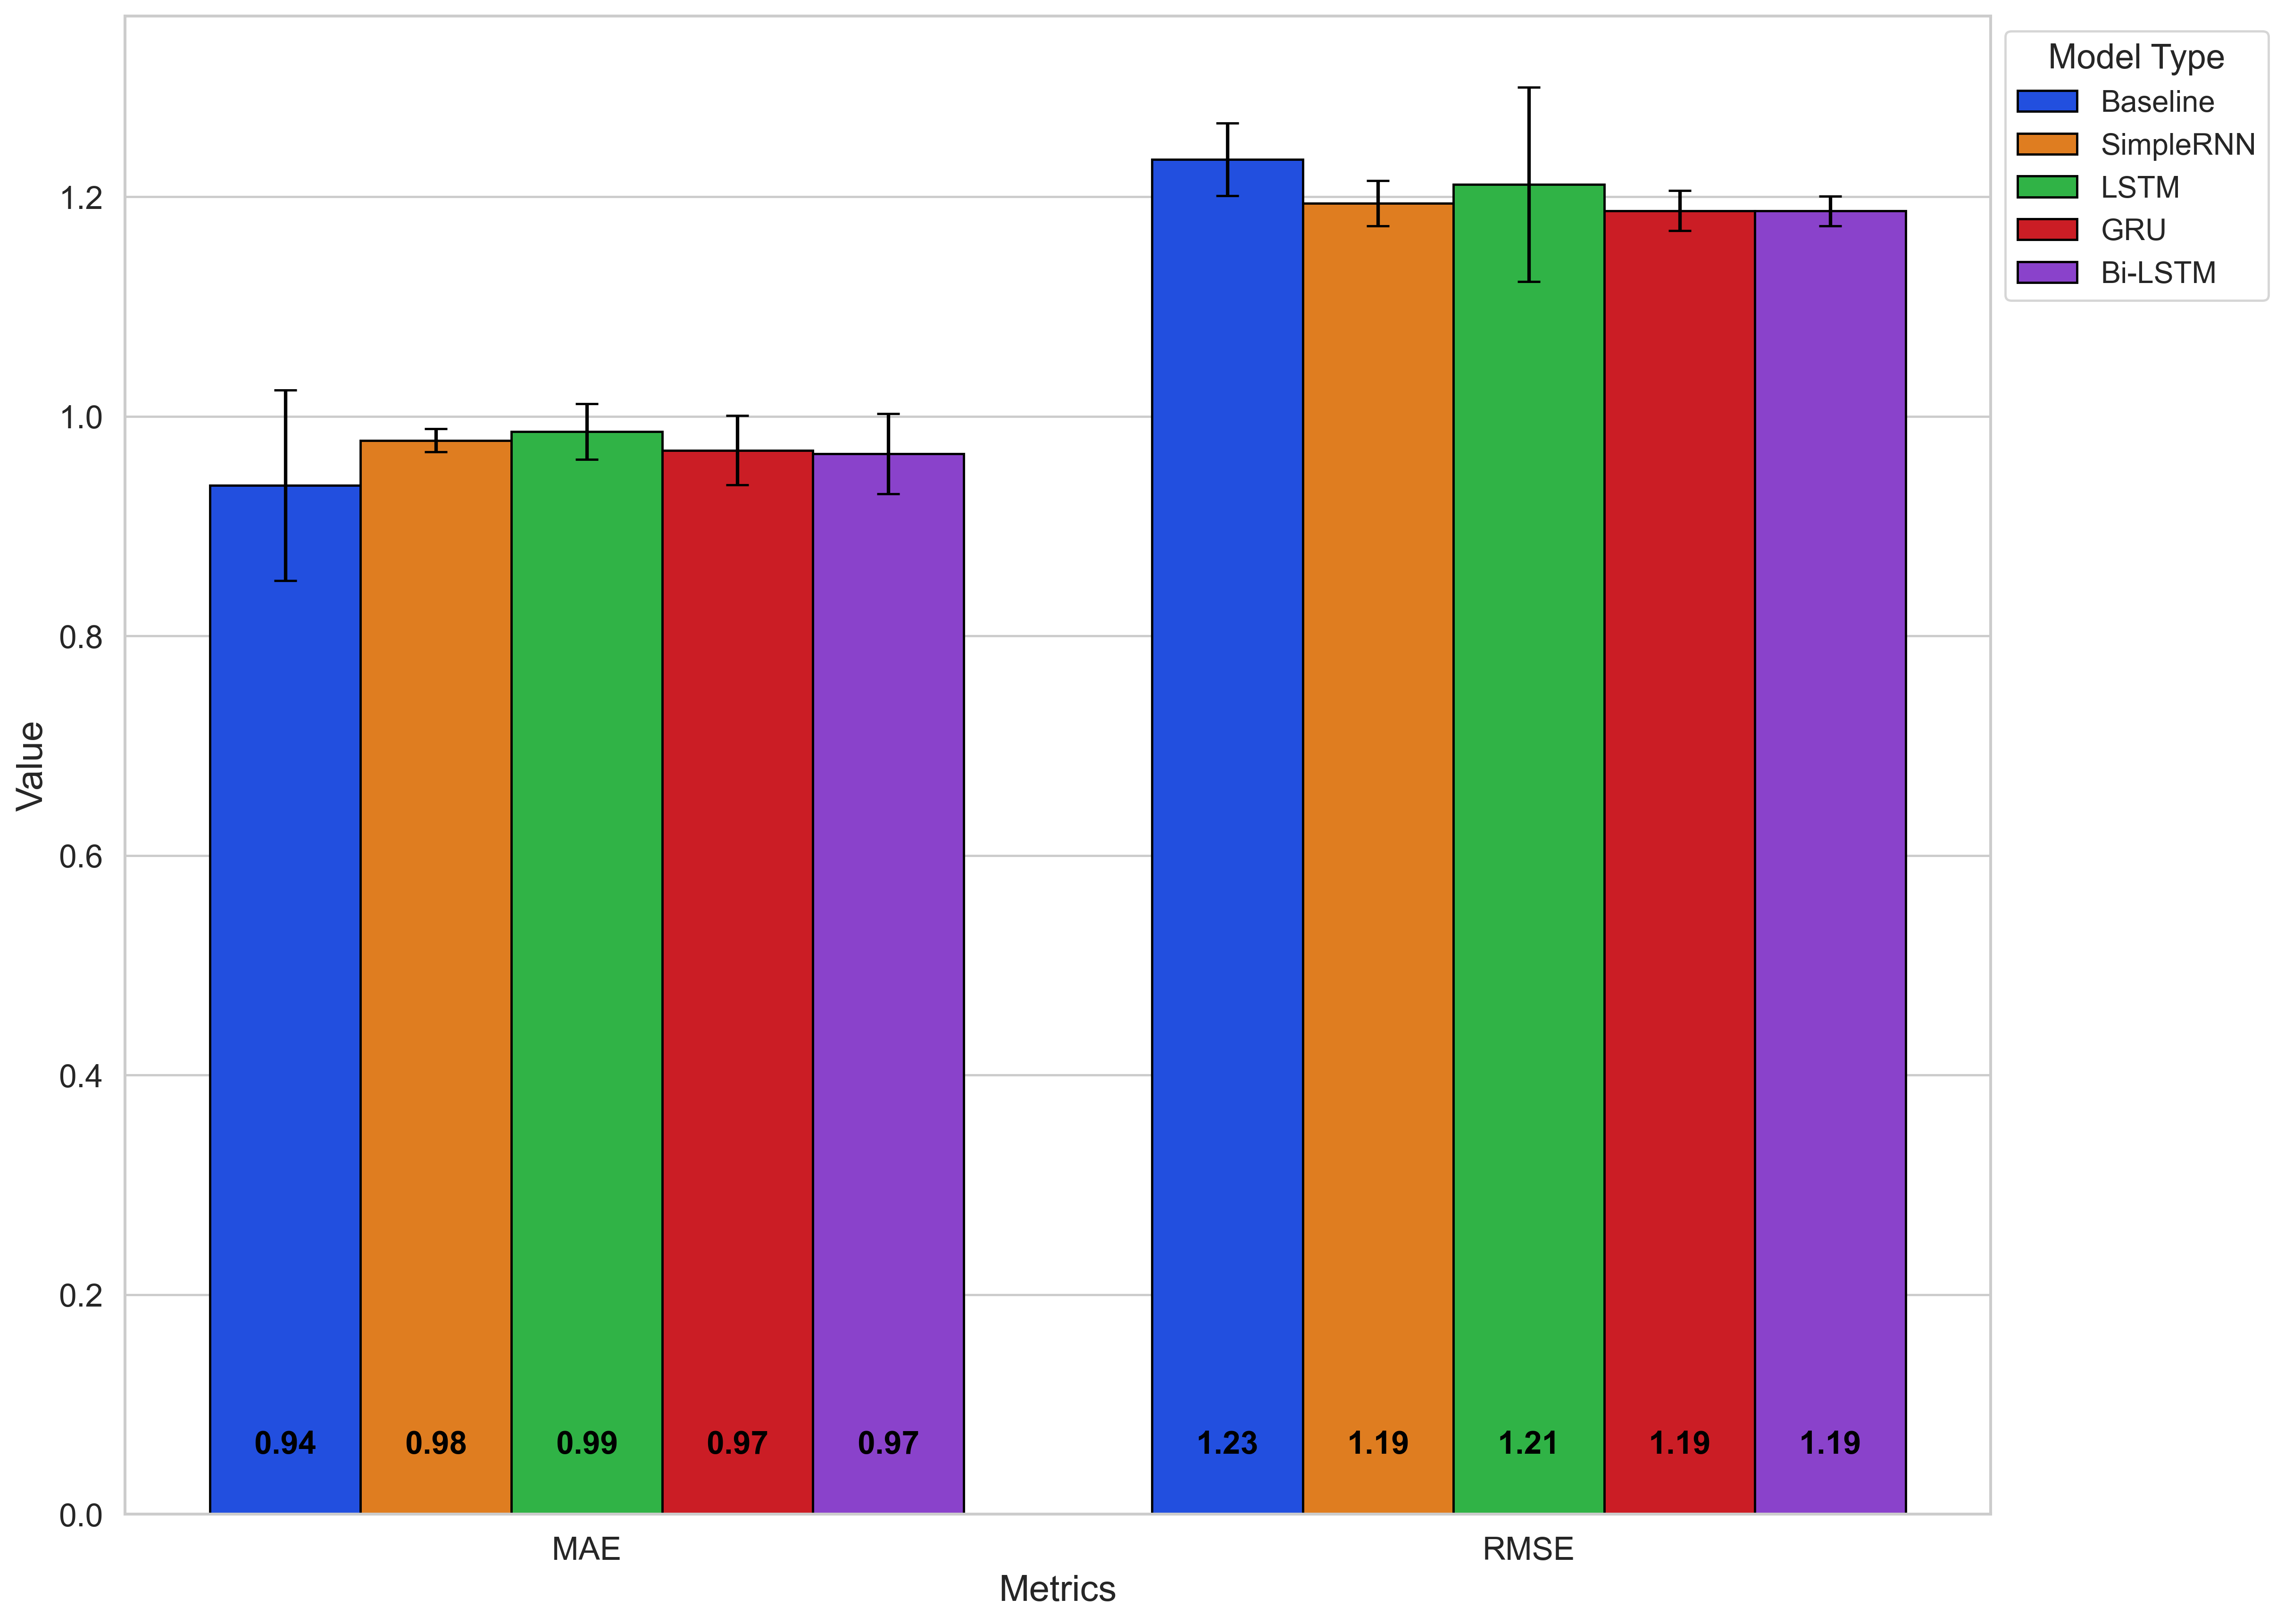

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Define the metrics folder
metrics_folder = "saved_models/ord_regr/metrics"



# Filter for GloVe embeddings and the relevant RNN types
rnn_types = ['simplernn', 'gru', 'lstm', 'bi-lstm']
glove_metrics = all_metrics[all_metrics['embedding'] == 'glove']
glove_rnn_metrics = glove_metrics[glove_metrics['rnn_layer'].isin(rnn_types)]

# Combine baseline and glove RNN metrics for comparison
baseline_metrics['rnn_layer'] = 'baseline'
combined_metrics = pd.concat([baseline_metrics, glove_rnn_metrics])

# Remove duplicates in index
combined_metrics = combined_metrics.reset_index(drop=True)

# Calculate mean and standard deviation for the metrics
mean_metrics = combined_metrics.groupby(['rnn_layer'])[['mae', 'mse', 'rmse']].mean().reset_index()
std_metrics = combined_metrics.groupby(['rnn_layer'])[['mae', 'mse', 'rmse']].std().reset_index()

# Ensure the order of rnn_layers
order = ['baseline', 'simplernn', 'lstm', 'gru', 'bi-lstm']
mean_metrics['rnn_layer'] = pd.Categorical(mean_metrics['rnn_layer'], categories=order, ordered=True)
std_metrics['rnn_layer'] = pd.Categorical(std_metrics['rnn_layer'], categories=order, ordered=True)
mean_metrics = mean_metrics.sort_values('rnn_layer')
std_metrics = std_metrics.sort_values('rnn_layer')

# Melt the data for easier plotting
mean_melted = mean_metrics.melt(id_vars=['rnn_layer'], var_name='metric', value_name='mean')
std_melted = std_metrics.melt(id_vars=['rnn_layer'], var_name='metric', value_name='std')

# Merge the mean and std data
plot_data = pd.merge(mean_melted, std_melted, on=['rnn_layer', 'metric'])

# Filter out MSE data
plot_data = plot_data[plot_data['metric'] != 'mse']

# Capitalize the metrics
plot_data['metric'] = plot_data['metric'].str.upper()

# Rename the rnn_layer values using ser.cat.rename_categories
plot_data['rnn_layer'] = plot_data['rnn_layer'].cat.rename_categories({
    'baseline': 'Baseline',
    'simplernn': 'SimpleRNN',
    'lstm': 'LSTM',
    'gru': 'GRU',
    'bi-lstm': 'Bi-LSTM'
})

# Ensure the output directory exists
output_dir = 'visuali/q1'
os.makedirs(output_dir, exist_ok=True)

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a bar plot with error bars
plt.figure(figsize=(14, 10), dpi=350)
bar_plot = sns.barplot(
    x='metric', 
    y='mean', 
    hue='rnn_layer', 
    data=plot_data, 
    errorbar=None,
    palette='bright',
    capsize=.1,
    edgecolor='black'
)

# Adding error bars and actual numbers on top of bars
for i, bar in enumerate(bar_plot.patches):
    if i < len(plot_data):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        yerr = plot_data.iloc[i]['std']
        bar_plot.errorbar(
            x, 
            height, 
            yerr=yerr, 
            fmt='none', 
            c='black', 
            capsize=5
        )
        bar_plot.text(
            x, 
            0.05,  # Just above the x axis
            f'{height:.2f}', 
            ha='center', 
            va='bottom', 
            fontsize=14,  # Increase font size
            fontweight='bold',  # Make the text bold
            color='black'
        )

# Adding labels and title
plt.xlabel('Metrics', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.legend(title='Model Type', bbox_to_anchor=(1, 1), loc='upper left', title_fontsize='15', fontsize='13')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()



C:\Users\flori\AppData\Local\Temp\ipykernel_13132\2913234360.py:53: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  plot_data['embedding'] = plot_data['embedding'].replace({


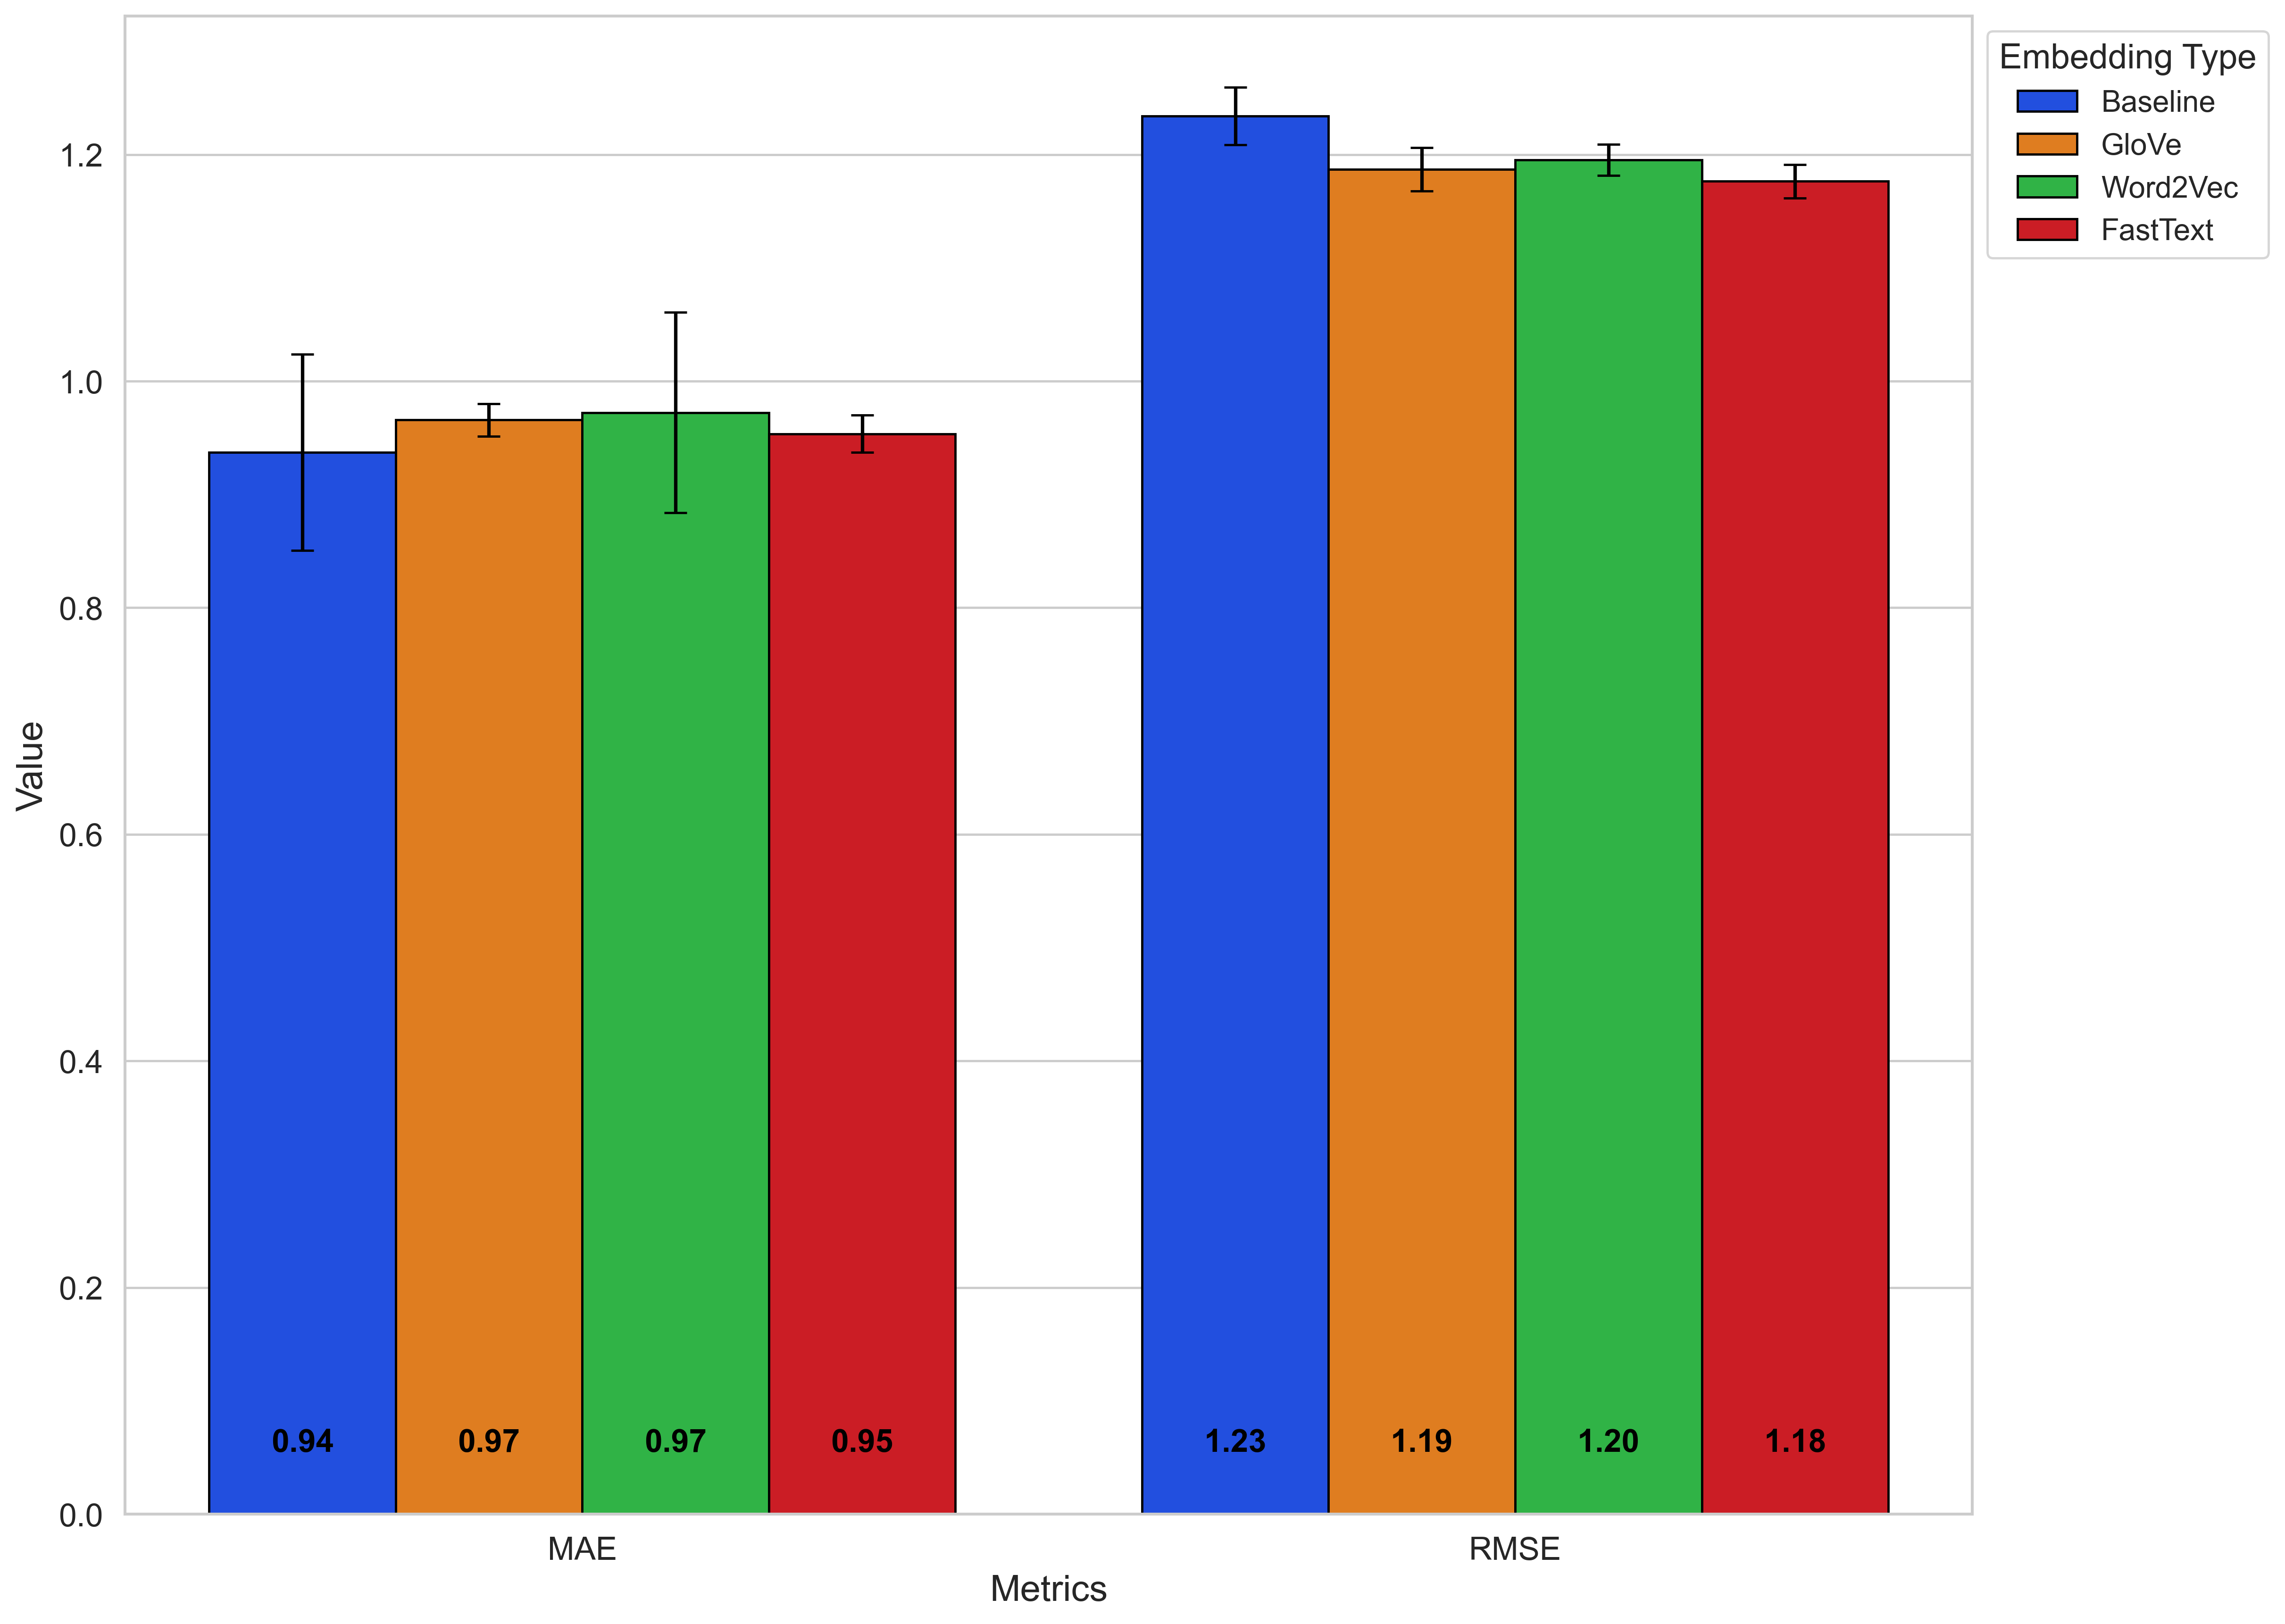

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os



# Filter for relevant embeddings and the relevant RNN type (bi-lstm)
embeddings = ['glove', 'word2vec', 'fasttext']
rnn_type = 'bi-lstm'
embedding_metrics = all_metrics[all_metrics['embedding'].isin(embeddings)]
embedding_rnn_metrics = embedding_metrics[embedding_metrics['rnn_layer'] == rnn_type]

# Combine baseline and embedding RNN metrics for comparison
baseline_metrics['rnn_layer'] = 'Baseline'
baseline_metrics['embedding'] = 'baseline'
combined_metrics = pd.concat([baseline_metrics, embedding_rnn_metrics])

# Remove duplicates in index
combined_metrics = combined_metrics.reset_index(drop=True)

# Calculate mean and standard deviation for the metrics
mean_metrics = combined_metrics.groupby(['embedding'])[['mae', 'mse', 'rmse']].mean().reset_index()
std_metrics = combined_metrics.groupby(['embedding'])[['mae', 'mse', 'rmse']].std().reset_index()

# Ensure the order of embeddings
order = ['baseline', 'glove', 'word2vec', 'fasttext']
mean_metrics['embedding'] = pd.Categorical(mean_metrics['embedding'], categories=order, ordered=True)
std_metrics['embedding'] = pd.Categorical(std_metrics['embedding'], categories=order, ordered=True)
mean_metrics = mean_metrics.sort_values('embedding')
std_metrics = std_metrics.sort_values('embedding')

# Melt the data for easier plotting
mean_melted = mean_metrics.melt(id_vars=['embedding'], var_name='metric', value_name='mean')
std_melted = std_metrics.melt(id_vars=['embedding'], var_name='metric', value_name='std')

# Merge the mean and std data
plot_data = pd.merge(mean_melted, std_melted, on=['embedding', 'metric'])

# Filter out MSE data
plot_data = plot_data[plot_data['metric'] != 'mse']

# Capitalize the metrics
plot_data['metric'] = plot_data['metric'].str.upper()

# Rename the embedding values
plot_data['embedding'] = plot_data['embedding'].replace({
    'baseline': 'Baseline',
    'glove': 'GloVe',
    'word2vec': 'Word2Vec',
    'fasttext': 'FastText'
})

# Ensure the output directory exists
output_dir = 'visuali/q2'
os.makedirs(output_dir, exist_ok=True)

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a bar plot with error bars
plt.figure(figsize=(14, 10), dpi=350)
bar_plot = sns.barplot(
    x='metric', 
    y='mean', 
    hue='embedding', 
    data=plot_data, 
    palette='bright',
    capsize=.1,
    edgecolor='black'
)

# Adding error bars and actual numbers on top of bars
for i, bar in enumerate(bar_plot.patches):
    if i < len(plot_data):
        height = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        yerr = plot_data.iloc[i]['std']
        bar_plot.errorbar(
            x, 
            height, 
            yerr=yerr, 
            fmt='none', 
            c='black', 
            capsize=5
        )
        bar_plot.text(
            x, 
            0.05,  
            f'{height:.2f}', 
            ha='center', 
            va='bottom', 
            fontsize=14,  # Increase font size
            fontweight='bold',  # Make the text bold
            color='black'
        )

# Adding labels and title
plt.xlabel('Metrics', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.legend(title='Embedding Type', bbox_to_anchor=(1, 1), loc='upper left', title_fontsize='15', fontsize='13')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save the plot
# plt.savefig(os.path.join(output_dir, 'metrics_comparison.png'), dpi=350)
plt.show()


In [110]:
import pandas as pd

# Load baseline and improved model metrics
metrics_folder = "saved_models/ord_regr/metrics"
baseline_metrics = pd.read_json(f'{metrics_folder}/baseline_metrics2.json')
all_metrics = pd.read_json(f'{metrics_folder}/all_metrics.json')

# Filter for relevant embeddings and the relevant RNN type (bi-lstm)
embeddings = ['glove', 'word2vec', 'fasttext']
embedding_metrics = all_metrics[all_metrics['embedding'].isin(embeddings)]
embedding_rnn_metrics = embedding_metrics[embedding_metrics['rnn_layer'] == 'bi-lstm']

# Combine baseline and embedding RNN metrics for comparison
baseline_metrics['rnn_layer'] = 'Baseline'
baseline_metrics['embedding'] = 'baseline'
combined_metrics = pd.concat([baseline_metrics, embedding_rnn_metrics])

# Select relevant columns
relevant_columns = ['embedding', 'accuracy', 'spearman_corr', 'qwk']
combined_relevant = combined_metrics[relevant_columns]

# Aggregate metrics by taking the mean for each embedding
agg_metrics = combined_relevant.groupby('embedding').mean().reset_index()

# Capitalize embedding names
agg_metrics['embedding'] = agg_metrics['embedding'].replace({
    'baseline': 'Baseline',
    'glove': 'GloVe',
    'word2vec': 'Word2Vec',
    'fasttext': 'FastText'
})

# Rename the columns for better readability
agg_metrics = agg_metrics.rename(columns={
    'embedding': 'Embedding Type',
    'accuracy': 'Accuracy',
    'spearman_corr': "Spearman's Rank Correlation",
    'qwk': "Cohen's Kappa"
})

# Print the comparison table
agg_metrics


Embedding Type  Accuracy  Spearman's Rank Correlation  Cohen's Kappa
0       Baseline  0.331677                     0.231723       0.222235
1       FastText  0.261626                     0.084070       0.057204
2          GloVe  0.255895                     0.066208       0.042221
3       Word2Vec  0.255895                     0.055059       0.035209

# Random Restarts

This section focuses on performing random restarts for model training to evaluate the consistency and reliability of the models.


In [19]:
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure reproducibility
random_state = 42

# Stratified split for train and test sets
X_agent_train, X_agent_test, X_external_train, X_external_test, y_train, y_test = train_test_split(
    X_agent, X_external, y, test_size=0.2, stratify=y, random_state=random_state)

# Stratified split for train and validation sets
X_agent_train, X_agent_val, X_external_train, X_external_val, y_train, y_val = train_test_split(
    X_agent_train, X_external_train, y_train, test_size=0.25, stratify=y_train, random_state=random_state)

print(f'X_agent_train shape: {X_agent_train.shape}')
print(f'X_external_train shape: {X_external_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_agent_val shape: {X_agent_val.shape}')
print(f'X_external_val shape: {X_external_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_agent_test shape: {X_agent_test.shape}')
print(f'X_external_test shape: {X_external_test.shape}')
print(f'y_test shape: {y_test.shape}')

# Combine train and validation sets for re-training
X_combined_agent = np.concatenate([X_agent_train, X_agent_val], axis=0)
X_combined_external = np.concatenate([X_external_train, X_external_val], axis=0)
y_combined = np.concatenate([y_train, y_val], axis=0)


X_agent_train shape: (735, 500)
X_external_train shape: (735, 500)
y_train shape: (735,)
X_agent_val shape: (246, 500)
X_external_val shape: (246, 500)
y_val shape: (246,)
X_agent_test shape: (246, 500)
X_external_test shape: (246, 500)
y_test shape: (246,)


In [8]:
import keras_tuner as kt
from keras_tuner import HyperModel
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError

# Define learning rate schedule
def decay_schedule(epoch, lr):
    return lr * 0.9 if epoch > 0 else lr

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.01)

# Define the TextHyperModel class with hyperparameter search space
class TextHyperModel(HyperModel):
    def build(self, hp):
        agent_input = Input(shape=(maxlen,), name='agent_input')
        external_input = Input(shape=(maxlen,), name='external_input')

        embedding_layer = Embedding(fasttext_matrix.shape[0], 
                                    fasttext_matrix.shape[1], 
                                    weights=[fasttext_matrix], 
                                    trainable=False)

        agent_embedding = embedding_layer(agent_input)
        external_embedding = embedding_layer(external_input)

        # Number of LSTM layers
        num_lstm_layers = hp.Int('num_lstm_layers', min_value=1, max_value=3)

        # Choice for the number of units in the last LSTM layer
        last_units = hp.Choice('last_units', values=[4, 8, 16])

        agent_lstm = agent_embedding
        external_lstm = external_embedding

        # Consistent dropout rate
        dropout_rate = hp.Float('dropout_rate', min_value=0.02, max_value=0.5, step=0.04)

        for i in range(num_lstm_layers):
            units = last_units * (2 ** (num_lstm_layers - i - 1))  # Double the units for each preceding layer
            agent_lstm = Bidirectional(LSTM(units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=(i < num_lstm_layers - 1)))(agent_lstm)
            external_lstm = Bidirectional(LSTM(units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=(i < num_lstm_layers - 1)))(external_lstm)

        # Number of dense layers
        num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=3)
        dense_units = last_units

        agent_dense = agent_lstm
        external_dense = external_lstm

        for i in range(num_dense_layers):
            agent_dense = Dense(dense_units, activation='relu')(agent_dense)
            agent_dense = Dropout(dropout_rate)(agent_dense)
            external_dense = Dense(dense_units, activation='relu')(external_dense)
            external_dense = Dropout(dropout_rate)(external_dense)
            dense_units //= 2  # Half the units for each subsequent dense layer

        concatenated = Concatenate()([agent_dense, external_dense])
        dense_layer = Dense(8, activation='relu')(concatenated)
        dense_layer = Dropout(dropout_rate)(dense_layer)

        output = Dense(1)(dense_layer)

        lr = hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])
        model = Model(inputs=[agent_input, external_input], outputs=output)
        model.compile(optimizer=Adam(learning_rate=lr), loss=MeanSquaredError(), metrics=['mae', 'mse'])

        return model
    
   


In [7]:

# Initialize the tuner
tuner = kt.RandomSearch(
    TextHyperModel(),
    objective='val_mse',
    max_trials=50,
    executions_per_trial=1,
    directory='my_dir',
    project_name='text_classification'
)





Reloading Tuner from my_dir\text_classification\tuner0.json


In [10]:
tuner.search([X_agent_train, X_external_train], y_train, epochs=100, validation_data=([X_agent_val, X_external_val], y_val), callbacks=[early_stopping])

Trial 50 Complete [00h 13m 35s]
val_mse: 1.171746850013733

Best val_mse So Far: 1.1507526636123657
Total elapsed time: 17h 53m 29s


In [ ]:
import json
import os
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, cohen_kappa_score, confusion_matrix
from scipy.stats import spearmanr
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

def evaluate_all_trials(tuner, X_test_agent, X_test_external, y_test):
    evaluation_results = []

    # Loop through all trials
    for trial in tuner.oracle.trials.values():
        # Load model using the hyperparameters from the trial
        hp = trial.hyperparameters
        model = tuner.hypermodel.build(hp)

        # Get the corresponding trial directory
        trial_id = trial.trial_id
        model_dir = os.path.join("my_dir", "text_classification", f"trial_{trial_id}")
        model_path = os.path.join(model_dir, "checkpoint.weights.h5")
        
        # Load model weights
        model.load_weights(model_path)
        
        # Evaluate the model
        results = model.evaluate([X_test_agent, X_test_external], y_test, verbose=0)
        
        # Calculate additional performance metrics
        y_pred = model.predict([X_test_agent, X_test_external])
        y_pred_classes = np.round(y_pred).astype(int)
        y_pred_classes = np.clip(y_pred_classes, 0, 3)
        mae = mean_absolute_error(y_test, y_pred_classes)
        mse = mean_squared_error(y_test, y_pred_classes)
        rmse = np.sqrt(mse)
        spearman_corr, _ = spearmanr(y_test, y_pred_classes)
        qwk = cohen_kappa_score(y_test, y_pred_classes, weights='quadratic')
        accuracy = accuracy_score(y_test, y_pred_classes)
        conf_matrix = confusion_matrix(y_test, y_pred_classes).tolist()
        
        metrics_entry = {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'spearman_corr': spearman_corr,
            'qwk': qwk,
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'hyperparameters': hp.values,
            'best_step': trial.best_step if hasattr(trial, 'best_step') else 'N/A'
        }
        
        evaluation_results.append(metrics_entry)
        print(f"Evaluation for Trial {trial_id}:")
        print(f"Test Loss (MSE): {results[0]}, Test MAE: {results[1]}")
        print(f"Additional metrics: {metrics_entry}")
    
    return evaluation_results

# Save results to a JSON file
def save_results_to_json(results, file_path):
    with open(file_path, 'w') as f:
        json.dump(results, f, indent=4)

# Example usage
evaluation_results = evaluate_all_trials(tuner, X_agent_test, X_external_test, y_test)
save_results_to_json(evaluation_results, 'all_evaluation_results.json')

# Sort by MSE and select the top 5 models
sorted_results = sorted(evaluation_results, key=lambda x: x['mse'])
top_5_results = sorted_results[:5]

# Save the top 5 results to a JSON file
save_results_to_json(top_5_results, 'top_5_evaluation_results.json')


# evaluation random restarts

In [54]:
import json
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, wilcoxon, shapiro

# Define paths to the JSON files
path_q1_q2 = r'saved_models\ord_regr\metrics\all_metrics_question_1_and_2.json.json'
path_baseline = r'saved_models\ord_regr\metrics\baseline_metrics2.json'

# Load the data
with open(path_q1_q2, 'r') as f:
    data_q1_q2 = json.load(f)

with open(path_baseline, 'r') as f:
    baseline_data = json.load(f)

# Extract performance metrics
metrics = ['mae', 'mse', 'rmse', 'spearman_corr', 'qwk', 'accuracy']

# Prepare data for Question 1 and 2
models = {}

for entry in data_q1_q2:
    model_name = f"{entry['embedding']}_{entry['rnn_layer']}"
    if model_name not in models:
        models[model_name] = {metric: [] for metric in metrics}
    for metric in metrics:
        models[model_name][metric].append(entry[metric])

# Prepare baseline metrics (assumed to be same for all folds)
baseline_metrics = {metric: [] for metric in metrics}

for entry in baseline_data:
    for metric in metrics:
        baseline_metrics[metric].append(entry[metric])

# Perform Shapiro-Wilk test for normality
normality_results = {model: {} for model in models}
baseline_normality_results = {}

for metric in metrics:
    baseline_shapiro = shapiro(baseline_metrics[metric])
    baseline_normality_results[metric] = baseline_shapiro

for model in models:
    for metric in metrics:
        model_shapiro = shapiro(models[model][metric])
        normality_results[model][metric] = model_shapiro

# Perform paired t-test or Wilcoxon signed-rank test
test_results = {model: {} for model in models}

for model in models:
    for metric in metrics:
        if baseline_normality_results[metric].pvalue > 0.05 and normality_results[model][metric].pvalue > 0.05:
            test_stat, p_value = ttest_rel(baseline_metrics[metric], models[model][metric])
            test_type = 'Paired t-test'
        else:
            test_stat, p_value = wilcoxon(baseline_metrics[metric], models[model][metric])
            test_type = 'Wilcoxon signed-rank test'
        test_results[model][metric] = {'test_type': test_type, 'test_stat': test_stat, 'p_value': p_value}


# Convert results to DataFrame for better display
normality_df = pd.DataFrame({model: {metric: normality_results[model][metric].pvalue for metric in metrics} for model in models})
paired_test_df = pd.DataFrame({model: {metric: test_results[model][metric]['p_value'] for metric in metrics} for model in models})
baseline_normality_df = pd.DataFrame(baseline_normality_results).T
baseline_normality_df.columns = ['W_statistic', 'p_value']

# Display DataFrames
print("Shapiro-Wilk Test Results for Baseline Metrics:")
baseline_normality_df

# Rename p_value column to baseline
baseline_normality_df.rename(columns={'p_value': 'baseline'}, inplace=True)

# Concatenate the DataFrames
combined_normality_df = pd.concat([normality_df, baseline_normality_df[['baseline']]], axis=1)

# Display the combined DataFrame
combined_normality_df



Shapiro-Wilk Test Results for Baseline Metrics:


glove_simplernn  glove_gru  glove_lstm  glove_bi-lstm  \
mae                   0.004908   0.961423    0.422468       0.681972   
mse                   0.882277   0.661736    0.470561       0.530581   
rmse                  0.896773   0.666007    0.468866       0.525979   
spearman_corr         0.732154   0.814415    1.000000       0.146455   
qwk                   0.378152   0.645664    0.295184       0.200013   
accuracy              0.909353   0.593014    0.504002       0.710802   

               word2vec_simplernn  word2vec_gru  word2vec_lstm  \
mae                      0.607417      0.098864       0.976043   
mse                      0.102053      0.028325       0.798066   
rmse                     0.098568      0.028572       0.781754   
spearman_corr            0.036485      1.000000       0.151496   
qwk                      0.115459      0.074152       0.189637   
accuracy                 0.459201      0.739496       0.098138   

               word2vec_bi-lstm  fasttext_simplernn  fasttext_gru  \
mae                    0.269894            0.170678      0.090826   
mse                    0.835723            0.316646      0.962416   
rmse                   0.837105            0.312437      0.972282   
spearman_corr          0.194920            1.000000      0.341627   
qwk                    0.195248            0.282608      0.639032   
accuracy               0.132657            0.645972      0.487109   

               fasttext_lstm  fasttext_bi-lstm  baseline  
mae                 0.205888          0.779117  0.098465  
mse                 0.387761          0.139814  0.225000  
rmse                0.388650          0.138345  0.171668  
spearman_corr       1.000000          0.390203  0.019942  
qwk                 0.916449          0.314404  0.026432  
accuracy            0.311524          0.054394  0.694524

In [59]:
# Filter for q1_df: column names containing 'glove'
q1_df = paired_test_df.filter(like='glove', axis=1)

# Filter for q2_df: column names containing 'bi-lstm'
q2_df = paired_test_df.filter(like='bi-lstm', axis=1)

# Filter for q1_normality_df: column names containing 'glove' and add 'baseline'
q1_normality_df = combined_normality_df.filter(like='glove', axis=1)
q1_normality_df = pd.concat([q1_normality_df, combined_normality_df['baseline']], axis=1).round(3)

# Filter for q2_normality_df: column names containing 'bi-lstm' and add 'baseline'
q2_normality_df = combined_normality_df.filter(like='bi-lstm', axis=1)
q2_normality_df = pd.concat([q2_normality_df, combined_normality_df['baseline']], axis=1).round(3)




In [60]:

# Display the filtered DataFrames
print("Q1 Normality DataFrame:")
q1_normality_df

Q1 Normality DataFrame:


glove_simplernn  glove_gru  glove_lstm  glove_bi-lstm  baseline
mae                      0.005      0.961       0.422          0.682     0.098
mse                      0.882      0.662       0.471          0.531     0.225
rmse                     0.897      0.666       0.469          0.526     0.172
spearman_corr            0.732      0.814       1.000          0.146     0.020
qwk                      0.378      0.646       0.295          0.200     0.026
accuracy                 0.909      0.593       0.504          0.711     0.695

In [57]:

# Display the filtered DataFrames
print("Q1 DataFrame:")
q1_df

Q1 DataFrame:


glove_simplernn  glove_gru  glove_lstm  glove_bi-lstm
mae                   0.312500   0.500683    0.242676       0.519350
mse                   0.278696   0.347270    0.544550       0.295012
rmse                  0.310758   0.372135    0.592060       0.324330
spearman_corr         0.062500   0.125000         NaN       0.062500
qwk                   0.062500   0.062500    0.062500       0.062500
accuracy              0.008661   0.014860    0.007042       0.017623

In [61]:
print("\nQ2 Normality DataFrame:")
q2_normality_df





Q2 Normality DataFrame:


glove_bi-lstm  word2vec_bi-lstm  fasttext_bi-lstm  baseline
mae                    0.682             0.270             0.779     0.098
mse                    0.531             0.836             0.140     0.225
rmse                   0.526             0.837             0.138     0.172
spearman_corr          0.146             0.195             0.390     0.020
qwk                    0.200             0.195             0.314     0.026
accuracy               0.711             0.133             0.054     0.695

In [63]:
print("\nQ2 DataFrame:")
q2_df.round(3)


Q2 DataFrame:


glove_bi-lstm  word2vec_bi-lstm  fasttext_bi-lstm
mae                    0.519             0.445             0.681
mse                    0.295             0.373             0.160
rmse                   0.324             0.409             0.178
spearman_corr          0.062             0.062             0.062
qwk                    0.062             0.062             0.062
accuracy               0.018             0.022             0.041

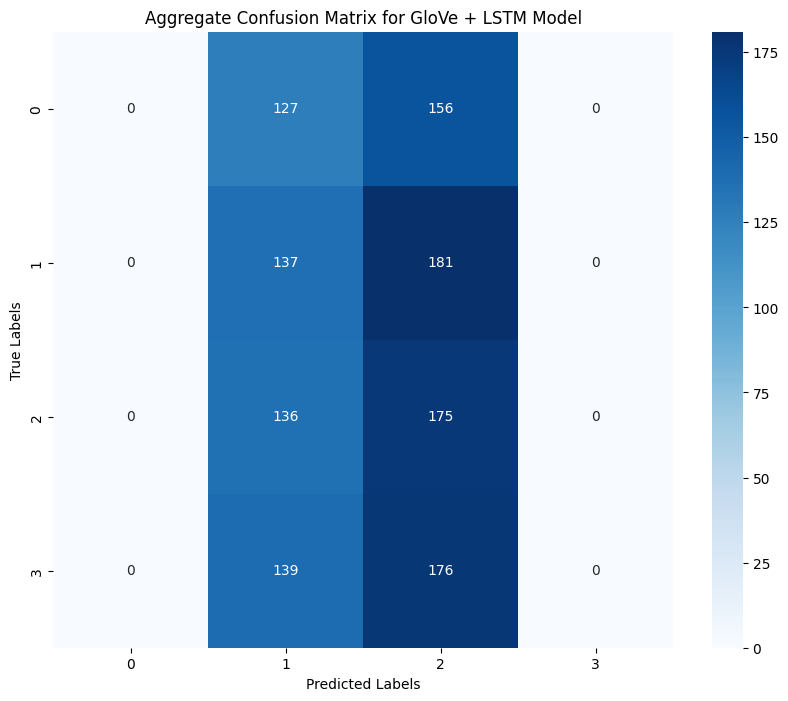

In [70]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming 'data_q1_q2' contains your DataFrame or loaded JSON data

# Filter and aggregate confusion matrices for GloVe + LSTM model
conf_matrices = []
for entry in data_q1_q2:
    if entry['embedding'] == 'glove' and entry['rnn_layer'] == 'lstm':
        conf_matrices.append(entry['confusion_matrix'])

# Aggregate confusion matrices
aggregate_conf_matrix = np.sum(conf_matrices, axis=0)

# Convert the aggregate confusion matrix to a DataFrame for better readability
conf_matrix_df = pd.DataFrame(aggregate_conf_matrix)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
plt.title('Aggregate Confusion Matrix for GloVe + LSTM Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [70]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
from scipy.stats import shapiro, bootstrap

# Define paths to the JSON files
path_baseline = r'saved_models\ord_regr\metrics\baseline_metrics2.json'
path_top5 = r'saved_models\ord_regr\metrics\top_5_evaluation_results_question3.json'

# Load the data from JSON files
with open(path_baseline, 'r') as f:
    baseline_data = json.load(f)

with open(path_top5, 'r') as f:
    top5_data = json.load(f)

# Define the metrics to be analyzed
metrics = ['mae', 'mse', 'spearman_corr', 'qwk', 'accuracy']

# Prepare baseline data
baseline_metrics = {metric: [] for metric in metrics}
for entry in baseline_data:
    for metric in metrics:
        if metric in entry:
            baseline_metrics[metric].append(entry[metric])

# Calculate means for baseline metrics
baseline_means = {metric: np.mean(baseline_metrics[metric]) for metric in metrics}

# Prepare top 5 model metrics
top5_metrics = {metric: [] for metric in metrics}
for entry in top5_data:
    for metric in metrics:
        if metric in entry:
            top5_metrics[metric].append(entry[metric])

# Create a DataFrame for better display
data = {'Baseline Mean': [baseline_means[metric] for metric in metrics]}
for i in range(5):
    data[f'Model {i+1}'] = [top5_metrics[metric][i] for metric in metrics]

comparison_df = pd.DataFrame(data, index=metrics).T
print(comparison_df[['spearman_corr', 'qwk', 'accuracy']])

# Perform Shapiro-Wilk test for normality on baseline metrics
normality_results = {}
for metric in metrics:
    shapiro_test = shapiro(baseline_metrics[metric])
    normality_results[metric] = shapiro_test

# Print Shapiro-Wilk test results
print("Shapiro-Wilk Test Results for Baseline Metrics:")
for metric, result in normality_results.items():
    print(f"{metric} - W: {result.statistic:.4f}, p-value: {result.pvalue:.4f}")

# Perform two-tailed bootstrap method using scipy's bootstrap function
def bootstrap_test(baseline_data, single_observation, num_samples=1000):
    res = bootstrap((np.array(baseline_data),), np.mean, vectorized=False, n_resamples=num_samples, method='percentile')
    bootstrap_means = res.bootstrap_distribution

    observed_mean = np.mean(baseline_data)
    abs_diff = np.abs(bootstrap_means - observed_mean)
    single_obs_diff = np.abs(single_observation - observed_mean)
    
    p_value = np.mean(abs_diff >= single_obs_diff)
    
    # Correcting the p-value to ensure it is two-tailed
    if p_value > 0.5:
        p_value = 2 * (1 - p_value)
    else:
        p_value = 2 * p_value
    
    return p_value

bootstrap_test_results = {}
num_samples = 1000
for metric in metrics:
    for i, observation in enumerate(top5_metrics[metric]):
        p_value = bootstrap_test(baseline_metrics[metric], observation, num_samples)
        bootstrap_test_results[f'{metric}_model_{i+1}'] = {'p_value': p_value}

# Print bootstrap test results
print("\nBootstrap Test Results:")
for metric, result in bootstrap_test_results.items():
    print(f"{metric} - p-value: {result['p_value']:.4f}")



               spearman_corr       qwk  accuracy
Baseline Mean       0.209715  0.203203  0.323554
Model 1             0.217921  0.163434  0.252033
Model 2             0.166441  0.124683  0.247967
Model 3             0.173980  0.122151  0.243902
Model 4             0.139692  0.103583  0.243902
Model 5             0.148429  0.093476  0.252033
Shapiro-Wilk Test Results for Baseline Metrics:
mae - W: 0.8105, p-value: 0.0985
mse - W: 0.8591, p-value: 0.2250
spearman_corr - W: 0.7316, p-value: 0.0199
qwk - W: 0.7445, p-value: 0.0264
accuracy - W: 0.9440, p-value: 0.6945

Bootstrap Test Results:
mae_model_1 - p-value: 0.9480
mae_model_2 - p-value: 0.3220
mae_model_3 - p-value: 0.2740
mae_model_4 - p-value: 0.2980
mae_model_5 - p-value: 0.2360
mse_model_1 - p-value: 0.0000
mse_model_2 - p-value: 0.0120
mse_model_3 - p-value: 0.0060
mse_model_4 - p-value: 0.0100
mse_model_5 - p-value: 0.0220
spearman_corr_model_1 - p-value: 0.3520
spearman_corr_model_2 - p-value: 0.9140
spearman_corr_model_3 - 

In [4]:
import json
import os

# Path to the directory containing the trial files
trials_directory = r"my_dir\text_classification"
import json
import os


# Best performing model hyperparameters and best step
best_hyperparameters = {
    "num_lstm_layers": 1,
    "last_units": 8,
    "dropout_rate": 0.1,
    "num_dense_layers": 1,
    "lr": 0.0001
}
best_step = 31

# Function to extract actual hyperparameters from a trial file
def extract_actual_hyperparameters(trial_file):
    with open(trial_file, 'r') as file:
        trial_data = json.load(file)
        hyperparameters = {}
        for hp in trial_data['hyperparameters']['values']:
            hyperparameters[hp] = trial_data['hyperparameters']['values'][hp]
        best_step = trial_data.get("best_step", None)
        return hyperparameters, best_step

# Find the matching trial file
matching_trial = None
for trial_dir in os.listdir(trials_directory):
    trial_file_path = os.path.join(trials_directory, trial_dir, "trial.json")
    if os.path.isfile(trial_file_path):
        actual_hyperparameters, trial_best_step = extract_actual_hyperparameters(trial_file_path)
        if actual_hyperparameters == best_hyperparameters and trial_best_step == best_step:
            matching_trial = trial_dir
            break

if matching_trial:
    print(f"Matching trial: {matching_trial}")
else:
    print("No matching trial found.")

Matching trial: trial_08


In [ ]:
import keras_tuner as kt
import json
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

# Load the trial configuration
with open(r'my_dir\text_classification\trial_08\trial.json', 'r') as f:
    trial_config = json.load(f)

# Extract the best hyperparameters
best_hp = trial_config['hyperparameters']['values']

# Instantiate the hypermodel
hypermodel = TextHyperModel()

# Rebuild the model using the best hyperparameters
hp = kt.HyperParameters()
hp.values = best_hp
model = hypermodel.build(hp)

# Load the weights
model.load_weights(r'my_dir\text_classification\trial_08\checkpoint.weights.h5')

# Check the model summary to confirm it has been loaded correctly
model.summary()


X_agent_train shape: (735, 500)
X_external_train shape: (735, 500)
y_train shape: (735,)
X_agent_val shape: (246, 500)
X_external_val shape: (246, 500)
y_val shape: (246,)
X_agent_test shape: (246, 500)
X_external_test shape: (246, 500)
y_test shape: (246,)
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step


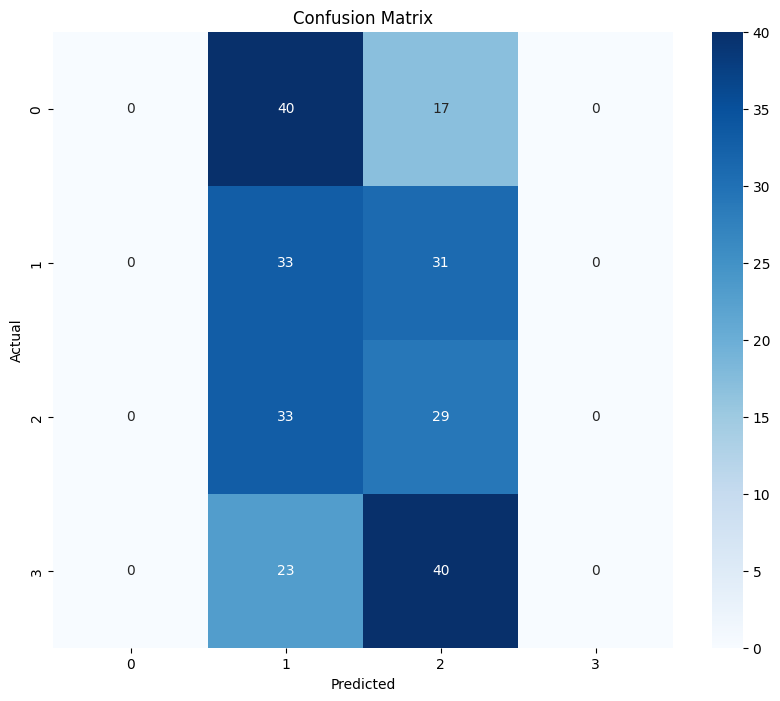

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure reproducibility
random_state = 42

# Generate sample data for illustration (replace this with actual data loading)
# X_agent, X_external, y should be defined before this step
# Example:
# X_agent = np.random.rand(1000, 500)
# X_external = np.random.rand(1000, 500)
# y = np.random.rand(1000)

# Define a function to convert indices back to text (dummy function, replace with actual implementation)
def indices_to_text(indices):
    return ["sample text" for _ in indices]

# Stratified split for train and test sets
X_agent_train, X_agent_test, X_external_train, X_external_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X_agent, X_external, y, np.arange(len(y)), test_size=0.2, stratify=y, random_state=random_state)

# Stratified split for train and validation sets
X_agent_train, X_agent_val, X_external_train, X_external_val, y_train, y_val, indices_train, indices_val = train_test_split(
    X_agent_train, X_external_train, y_train, indices_train, test_size=0.25, stratify=y_train, random_state=random_state)

print(f'X_agent_train shape: {X_agent_train.shape}')
print(f'X_external_train shape: {X_external_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_agent_val shape: {X_agent_val.shape}')
print(f'X_external_val shape: {X_external_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_agent_test shape: {X_agent_test.shape}')
print(f'X_external_test shape: {X_external_test.shape}')
print(f'y_test shape: {y_test.shape}')

# Combine train and validation sets for re-training
X_combined_agent = np.concatenate([X_agent_train, X_agent_val], axis=0)
X_combined_external = np.concatenate([X_external_train, X_external_val], axis=0)
y_combined = np.concatenate([y_train, y_val], axis=0)

# Re-train the model on the combined training and validation set
# model.fit([X_combined_agent, X_combined_external], y_combined, epochs=10, batch_size=32)

# Evaluate the model on the test set
y_pred = model.predict([X_agent_test, X_external_test])

# Calculate residuals
residuals = y_test - y_pred.squeeze()

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test.round(), y_pred.round())

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


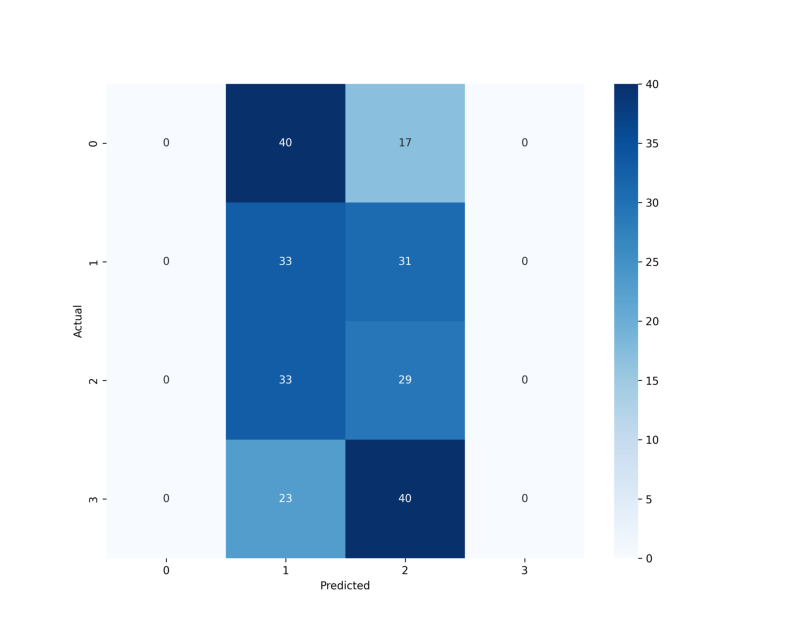

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

# Load JSON file
metrics_file = r"saved_models\ord_regr\metrics\top_5_evaluation_results_question3.json" 
with open(metrics_file) as f:
    metrics_data = json.load(f)

# Function to plot and save the confusion matrix
def plot_confusion_matrix(cm, model_name, output_dir):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # plt.title(f'Confusion Matrix for {model_name}')
    plt.savefig(os.path.join(output_dir, f'{model_name}_confusion_matrix.png'), dpi=300)  # Higher DPI
    plt.close()

# Ensure the output directory exists
output_dir = 'visuali/confusion_matrices'
os.makedirs(output_dir, exist_ok=True)

# Iterate through the results and plot confusion matrices
for idx, result in enumerate(metrics_data):
    cm = result['confusion_matrix']
    model_name = f"Model_{idx+1}"
    plot_confusion_matrix(cm, model_name, output_dir)

# Displaying the first matrix as an example
import matplotlib.image as mpimg
img = mpimg.imread(os.path.join(output_dir, 'Model_1_confusion_matrix.png'))
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()


In [75]:
import pandas as pd
import json


# Extract hyperparameters
hyperparameters_list = []
for idx, result in enumerate(metrics_data):
    hyperparams = result['hyperparameters']
    hyperparams['model'] = f"Model_{idx+1}"
    hyperparameters_list.append(hyperparams)

# Create a DataFrame
df_hyperparameters = pd.DataFrame(hyperparameters_list)

# Display the DataFrame
df_hyperparameters


num_lstm_layers  last_units  dropout_rate  num_dense_layers      lr  \
0                1           8          0.10                 1  0.0001   
1                1          16          0.02                 2  0.0010   
2                3           8          0.10                 1  0.0001   
3                1          16          0.06                 3  0.0100   
4                2           4          0.06                 1  0.0010   

     model  
0  Model_1  
1  Model_2  
2  Model_3  
3  Model_4  
4  Model_5

# Error analysis and EDA

## plotting of decisive features for correct and incorrect classifications

In [15]:

# Find 5 samples with the highest residuals
highest_residuals_indices = np.argsort(np.abs(residuals))[-5:]
highest_residuals = residuals[highest_residuals_indices]
highest_residuals_samples = [(indices_test[i], y_test[i], y_pred[i]) for i in highest_residuals_indices]

# Find 5 samples with the lowest residuals
lowest_residuals_indices = np.argsort(np.abs(residuals))[:5]
lowest_residuals = residuals[lowest_residuals_indices]
lowest_residuals_samples = [(indices_test[i], y_test[i], y_pred[i]) for i in lowest_residuals_indices]

# Convert indices to text (replace with actual implementation)
highest_residuals_texts = indices_to_text([sample[0] for sample in highest_residuals_samples])
lowest_residuals_texts = indices_to_text([sample[0] for sample in lowest_residuals_samples])

# Print the results
print("Samples with highest residuals:")
for i, sample in enumerate(highest_residuals_samples):
    print(f"Sample {i+1}:")
    print(f"Original index: {sample[0]}")
    print(f"Original text: {highest_residuals_texts[i]}")
    print(f"True value: {sample[1]}")
    print(f"Predicted value: {sample[2]}")
    print(f"Residual: {highest_residuals[i]}")
    print()

print("Samples with lowest residuals:")
for i, sample in enumerate(lowest_residuals_samples):
    print(f"Sample {i+1}:")
    print(f"Original index: {sample[0]}")
    print(f"Original text: {lowest_residuals_texts[i]}")
    print(f"True value: {sample[1]}")
    print(f"Predicted value: {sample[2]}")
    print(f"Residual: {lowest_residuals[i]}")
    print()


Samples with highest residuals:
Sample 1:
Original index: 34
Original text: hey chris around uh kyle good go supposed call finish right thank mm ok hey chris going problem busy day oh mac cheese oh hey good vegan mac cheese wife like vegetarian leans pretty hard like vegan like made vegan mac cheese pretty good yeah give dairy though still like normal day sometimes one thing really able give eat yeah eat eggs allergic avocado sometimes like kind tough like get protein needs yeah love like two years ago like told like right gonna like pescatarian like week like indulge like normal meat weekends year yeah um yeah fine like know made like stop think got lazy yeah mean go lot weeks even even fish week would like like mostly plant based fine yeah yeah bad know yeah mhm like junk food people vegan vegetarian know yeah yeah um ok oh ok ok ok ok never heard know yeah think feel like bought viola stuff trying think another one bought know like butter wise would get like pretty good yeah um thin

In [16]:
# Step 1: Import the necessary libraries
from lime.lime_text import LimeTextExplainer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

# Ensure proper handling of inputs and outputs in predict_texts function
def predict_texts(texts):
    # Convert list of combined texts back to separate lists of agent and external texts
    agent_texts = [text.split(' ')[0] for text in texts]  # Assuming a simple split can separate the texts correctly
    external_texts = [text.split(' ')[1] for text in texts]
    
    # Convert texts to sequences and pad them
    agent_seqs = tokenizer.texts_to_sequences(agent_texts)
    external_seqs = tokenizer.texts_to_sequences(external_texts)
    agent_data = pad_sequences(agent_seqs, maxlen=1000)
    external_data = pad_sequences(external_seqs, maxlen=1000)
    
    # Predict using the loaded model
    preds = model.predict([agent_data, external_data])
    
    # Convert predictions to probabilities for each class
    preds = np.clip(preds, 0, 3)  # Ensure predictions are within the valid range
    pred_probs = np.zeros((preds.shape[0], 4))
    for i in range(4):
        pred_probs[:, i] = np.exp(-(preds.squeeze() - i) ** 2)
    
    return pred_probs
# Step 2: Import the necessary library for LIME
from lime.lime_text import LimeTextExplainer
import numpy as np

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=['0', '1', '2', '3'])

# Function to convert indices back to text
def indices_to_text(indices):
    agent_texts = [df.iloc[i]['clean_agent'] for i in indices]
    external_texts = [df.iloc[i]['clean_external'] for i in indices]
    combined_texts = [agent + " " + external for agent, external in zip(agent_texts, external_texts)]
    return combined_texts

# Get texts for highest residuals
highest_residuals_texts = indices_to_text([sample[0] for sample in highest_residuals_samples])
lowest_residuals_texts = indices_to_text([sample[0] for sample in lowest_residuals_samples])

# Perform LIME analysis on highest residuals
print("LIME Explanations for Samples with Highest Residuals:")
for i, text in enumerate(highest_residuals_texts):
    exp = explainer.explain_instance(text, predict_texts, num_features=10, num_samples=500)
    print(f"Sample {i+1}: Original index: {highest_residuals_samples[i][0]}")
    print(exp.as_list())
    print()

# Perform LIME analysis on lowest residuals
print("LIME Explanations for Samples with Lowest Residuals:")
for i, text in enumerate(lowest_residuals_texts):
    exp = explainer.explain_instance(text, predict_texts, num_features=10, num_samples=500)
    print(f"Sample {i+1}: Original index: {lowest_residuals_samples[i][0]}")
    print(exp.as_list())
    print()


LIME Explanations for Samples with Highest Residuals:
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step
Sample 1: Original index: 34
[('hey', 0.054947129255516536), ('chris', 0.015379937792369715), ('tub', 0.0002322941244300177), ('show', 0.00022738971129713752), ('river', 0.000209927964392673), ('routing', 0.00010254049392362455), ('reasons', 4.875005332688286e-05), ('freaking', -3.158606903390657e-05), ('checking', 2.1035624874925808e-05), ('oh', 1.3369883108772011e-05)]

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step
Sample 2: Original index: 1084
[('hey', 0.05428239980975958), ('eddie', 0.021793398167889347), ('system', 0.000323272794143416), ('forwarded', 0.00030211107966351264), ('voice', 0.0002894558835889061), ('good', 0.00021159467462988782), ('us', -5.811725121579448e-05), ('tone', 4.976749726389097e-05), ('thank', 1.579248546005056e-05), ('back', -8.493291021413636e-06)]

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
Sample 3: Original index: 447
[('hey', 0.05583393069206686), ('giovanni', 0.00

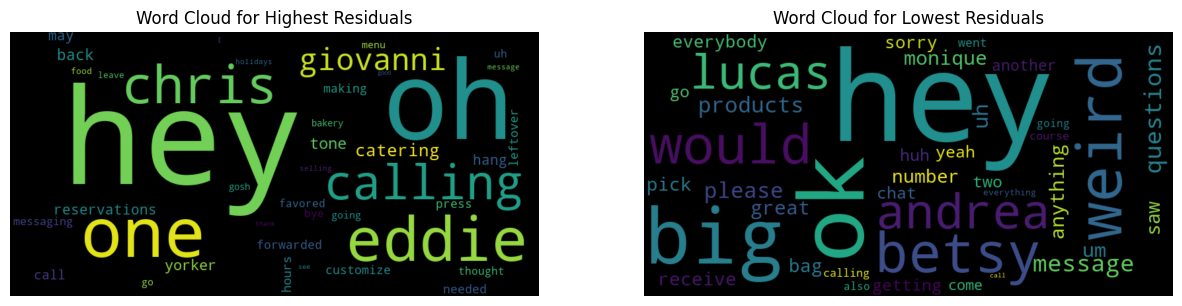

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine LIME explanations
def combine_explanations(explanations):
    combined_explanations = {}
    for explanation in explanations:
        for word, weight in explanation:
            if word in combined_explanations:
                combined_explanations[word] += weight
            else:
                combined_explanations[word] = weight
    return combined_explanations

# LIME explanations for samples with highest residuals
highest_residuals_explanations = [
    [('hey', 0.0548057786787431), ('chris', 0.015452729572704273), ('yorker', 0.0003393488785953658), ('customize', 0.00021598931160124953), ('making', 0.00019363527279246787), ('menu', 0.00011008228285335899), ('dog', -0.0001057617009416497), ('gosh', 9.459856536595128e-05), ('holidays', 5.0645333470779955e-05), ('wow', 6.853496245639033e-06)],
    [('hey', 0.05389520341693859), ('eddie', 0.02141691323778618), ('tone', 0.00038340203741269954), ('may', 0.00032136492027439535), ('hang', 0.0003126641800705241), ('leftover', 0.00020841215057317694), ('press', 0.00020426895383484093), ('forwarded', 0.00018576803803932465), ('messaging', 0.00016298004359075312), ('uh', 8.941099396485796e-06)],
    [('hey', 0.05591564600682322), ('giovanni', 0.0035929690904772404), ('needed', 0.0002112111797406889), ('bye', 0.00013704874119906666), ('favored', 0.00013596299053410355), ('uh', 0.00013276739559282117), ('going', 0.00011609401021310893), ('go', 0.00011293322317411084), ('message', 5.0945514338405865e-05), ('see', 4.269584958852801e-05)],
    [('one', 0.028198622469211457), ('calling', 0.012520050765017362), ('thought', 0.00012876248213555285), ('bakery', 9.752437075522692e-05), ('leave', 8.175770309025378e-05), ('food', 8.079353866911245e-05), ('selling', 4.9407271201769724e-05), ('thank', 4.168498636688916e-05), ('good', 3.337690613371482e-05), ('give', -1.0475017191888137e-06)],
    [('oh', 0.10540929131911424), ('catering', 0.00045929325297189435), ('back', 0.0003570890156626152), ('calling', 0.00032263796941238963), ('reservations', 0.0003211172154079867), ('call', 0.0002799983662750592), ('hours', 0.0002563424658949393), ('notch', -0.00018516880277652176), ('address', -0.00014740827405839774), ('event', -9.372469007313339e-05)]
]

# LIME explanations for samples with lowest residuals
lowest_residuals_explanations = [
    [('hey', 0.05459717792236334), ('lucas', 0.01800992245715608), ('saw', 0.00029506286183584473), ('two', 0.00019452839789322495), ('go', 0.00018881431884024122), ('chat', 0.0001875483562276845), ('went', 8.510196719270391e-05), ('going', 6.869641876167701e-05), ('everything', 3.8524117281368535e-05), ('call', 2.177873794885566e-05)],
    [('hey', 0.05388009254001504), ('betsy', 0.024752123937303184), ('products', 0.00037677511835882495), ('great', 0.00030706070726725833), ('receive', 0.00026963799777984034), ('bag', 0.00025699160398519544), ('everybody', 0.0002220477712527299), ('calling', 7.40991738198872e-05), ('check', -4.892339165735881e-05), ('lucas', -3.829526924174979e-05)],
    [('ok', 0.07314197013281067), ('weird', 0.03176899794871655), ('questions', 0.0004690561888535294), ('message', 0.00046350128791672996), ('monique', 0.00031760245159179277), ('please', 0.00031568850986506115), ('leave', -0.00027875590310259417), ('number', 0.00026605306152071163), ('see', -8.587733497294781e-05), ('good', -2.144443138504813e-05)],
    [('big', 0.0519282671181369), ('would', 0.02385569572625063), ('sorry', 0.00021437458385232652), ('yeah', 0.00019348846949084067), ('huh', 0.00018899897836233644), ('another', 0.0001532026846883446), ('come', 0.00013458815311155866), ('course', 7.866178505403975e-05), ('please', 6.140079702988776e-05), ('team', -4.8008288955589353e-05)],
    [('hey', 0.05441641419226892), ('andrea', 0.018914389620594677), ('uh', 0.00036358430254699843), ('um', 0.0003131147794138718), ('anything', 0.0003095959934465657), ('pick', 0.00026476743416064294), ('getting', 0.0001905164909068829), ('ok', -0.00014647974526132675), ('kind', -7.284060283331865e-05), ('also', 6.590748259806176e-05)]
]

# Combine explanations
highest_residuals_combined = combine_explanations(highest_residuals_explanations)
lowest_residuals_combined = combine_explanations(lowest_residuals_explanations)

# Create word clouds
highest_residuals_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(highest_residuals_combined)
lowest_residuals_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(lowest_residuals_combined)

# Display word clouds
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(highest_residuals_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Highest Residuals')

plt.subplot(1, 2, 2)
plt.imshow(lowest_residuals_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Lowest Residuals')

plt.show()


In [18]:
import numpy as np

# Calculate residuals
residuals = y_test - y_pred.squeeze()

# Identify high negative residuals (overestimations)
high_neg_residuals_indices = np.argsort(residuals)[:10]
high_neg_residuals = residuals[high_neg_residuals_indices]
high_neg_residuals_samples = [(indices_test[i], y_test[i], y_pred[i]) for i in high_neg_residuals_indices]

# Identify high positive residuals (underestimations)
high_pos_residuals_indices = np.argsort(residuals)[-10:]
high_pos_residuals = residuals[high_pos_residuals_indices]
high_pos_residuals_samples = [(indices_test[i], y_test[i], y_pred[i]) for i in high_pos_residuals_indices]

# Identify correctly classified samples (low residuals)
correct_residuals_indices = np.argsort(np.abs(residuals))[:10]
correct_residuals = residuals[correct_residuals_indices]
correct_residuals_samples = [(indices_test[i], y_test[i], y_pred[i]) for i in correct_residuals_indices]

# Function to convert indices back to text
def indices_to_text(indices):
    agent_texts = [df.iloc[i]['clean_agent'] for i in indices]
    external_texts = [df.iloc[i]['clean_external'] for i in indices]
    combined_texts = [agent + " " + external for agent, external in zip(agent_texts, external_texts)]
    return combined_texts

# Get texts for each category
high_neg_residuals_texts = indices_to_text([sample[0] for sample in high_neg_residuals_samples])
high_pos_residuals_texts = indices_to_text([sample[0] for sample in high_pos_residuals_samples])
correct_residuals_texts = indices_to_text([sample[0] for sample in correct_residuals_samples])


In [19]:
from lime.lime_text import LimeTextExplainer

# Initialize LIME explainer
explainer = LimeTextExplainer(class_names=['0', '1', '2', '3'])

# Function to run LIME analysis and get word weights
def get_lime_explanations(texts):
    explanations = []
    for text in texts:
        exp = explainer.explain_instance(text, predict_texts, num_features=10, num_samples=500)
        explanations.append(exp.as_list())
    return explanations

# Perform LIME analysis for each category
high_neg_residuals_explanations = get_lime_explanations(high_neg_residuals_texts)
high_pos_residuals_explanations = get_lime_explanations(high_pos_residuals_texts)
correct_residuals_explanations = get_lime_explanations(correct_residuals_texts)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
16/16 ━━━━━━━━━━

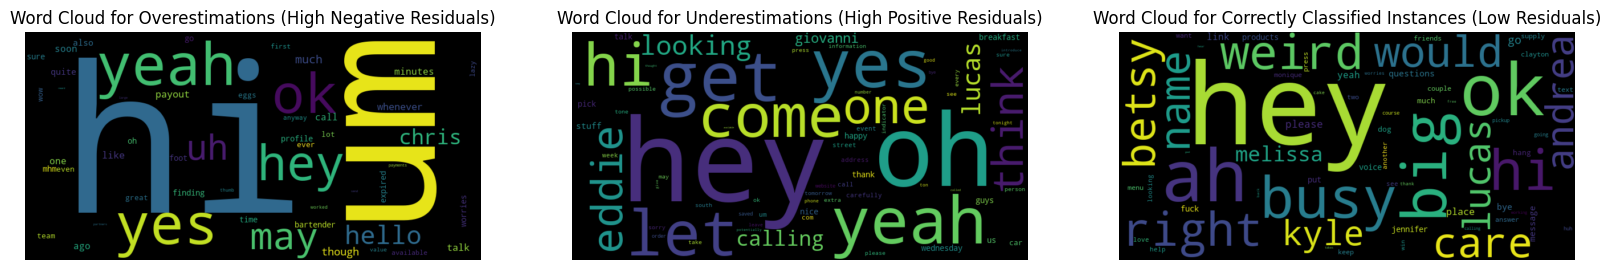

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine LIME explanations
def combine_explanations(explanations):
    combined_explanations = {}
    for explanation in explanations:
        for word, weight in explanation:
            if word in combined_explanations:
                combined_explanations[word] += weight
            else:
                combined_explanations[word] = weight
    return combined_explanations

# Combine explanations for each category
high_neg_residuals_combined = combine_explanations(high_neg_residuals_explanations)
high_pos_residuals_combined = combine_explanations(high_pos_residuals_explanations)
correct_residuals_combined = combine_explanations(correct_residuals_explanations)

# Create word clouds
high_neg_residuals_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(high_neg_residuals_combined)
high_pos_residuals_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(high_pos_residuals_combined)
correct_residuals_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(correct_residuals_combined)

# Display word clouds
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(high_neg_residuals_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Overestimations (High Negative Residuals)')

plt.subplot(1, 3, 2)
plt.imshow(high_pos_residuals_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Underestimations (High Positive Residuals)')

plt.subplot(1, 3, 3)
plt.imshow(correct_residuals_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Correctly Classified Instances (Low Residuals)')

plt.show()


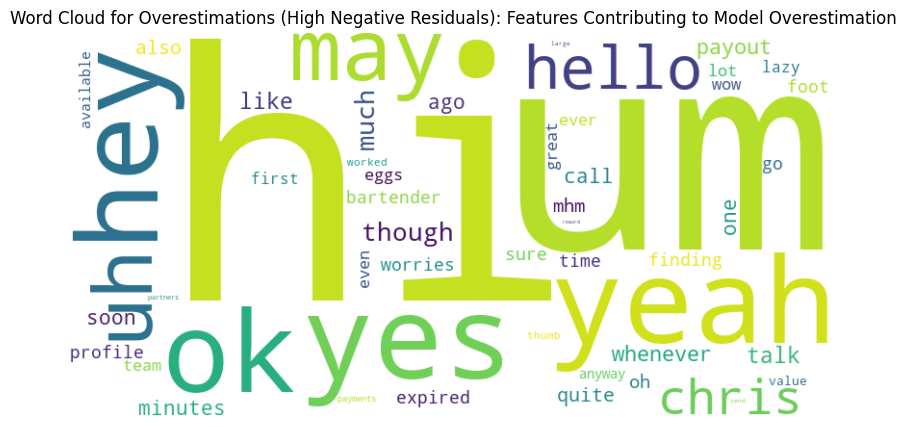

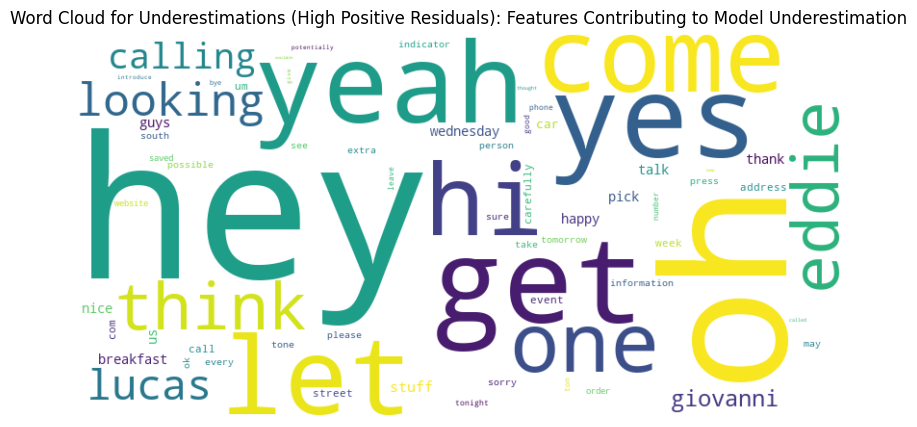

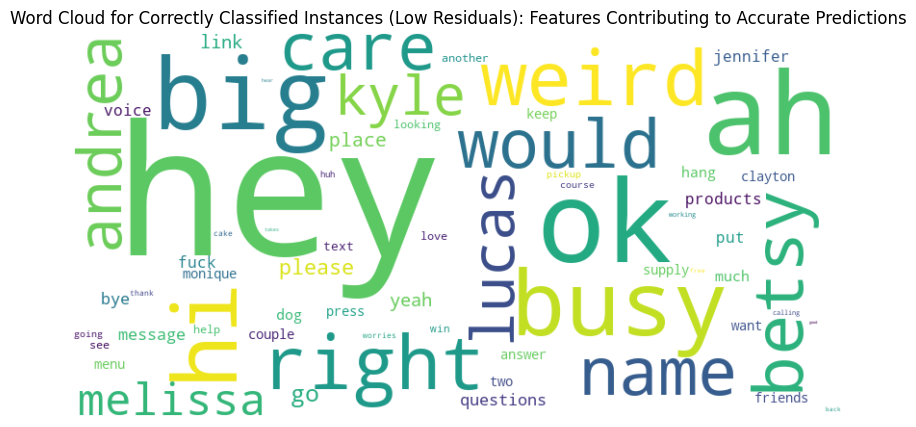

In [21]:
# Generate word clouds
high_neg_residuals_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(high_neg_residuals_combined)
high_pos_residuals_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(high_pos_residuals_combined)
correct_residuals_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(correct_residuals_combined)

# Display word clouds in separate plots
plt.figure(figsize=(10, 5))
plt.imshow(high_neg_residuals_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Overestimations (High Negative Residuals): Features Contributing to Model Overestimation')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(high_pos_residuals_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Underestimations (High Positive Residuals): Features Contributing to Model Underestimation')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(correct_residuals_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Correctly Classified Instances (Low Residuals): Features Contributing to Accurate Predictions')
plt.show()



## plotting of residuals

y_test size: (246,)
y_pred size: (246, 1)


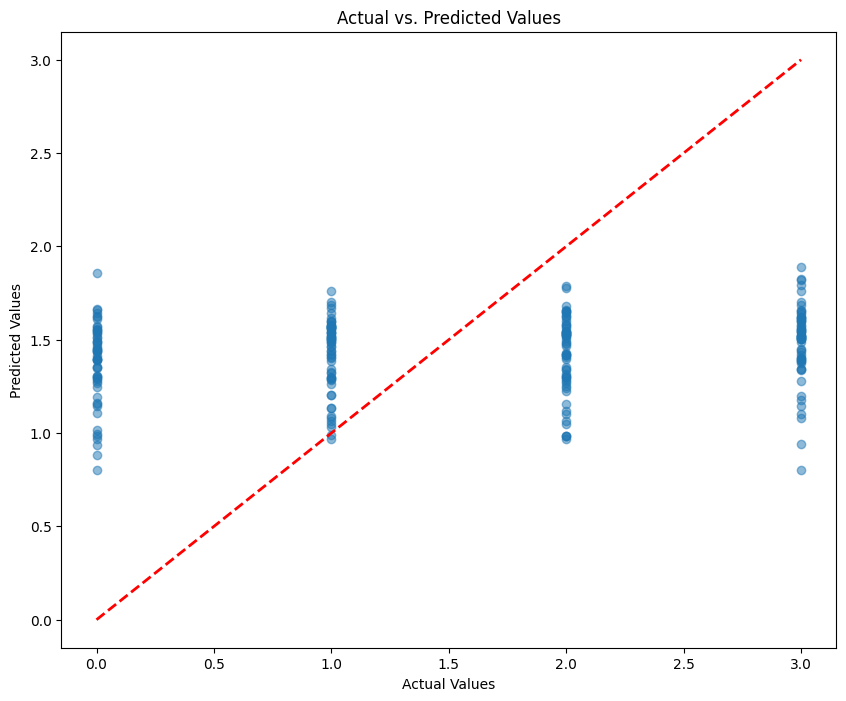

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Check the sizes of y_test and y_pred
print(f'y_test size: {y_test.shape}')
print(f'y_pred size: {y_pred.shape}')

# Ensure both are of the same size
if len(y_test) != len(y_pred):
    raise ValueError("y_test and y_pred must be the same size for plotting.")

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)  # Line for perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()


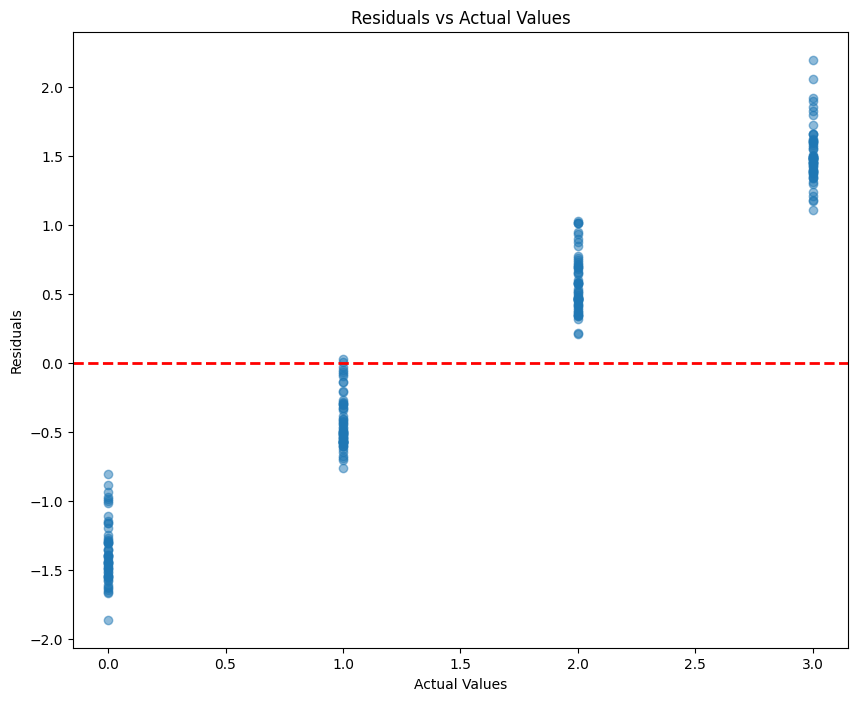

In [23]:
import matplotlib.pyplot as plt

# Ensure residuals calculation
residuals = y_test - y_pred.squeeze()

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)  # Line for zero residuals
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Values')
plt.show()


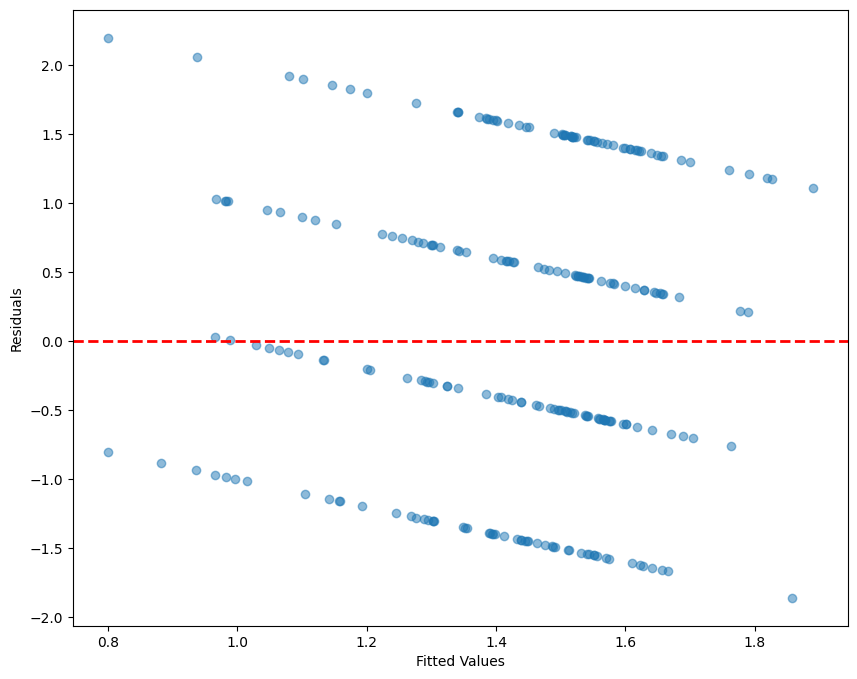

In [24]:
plt.figure(figsize=(10, 8))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
# plt.title('Residuals vs. Fitted Values')
plt.show()


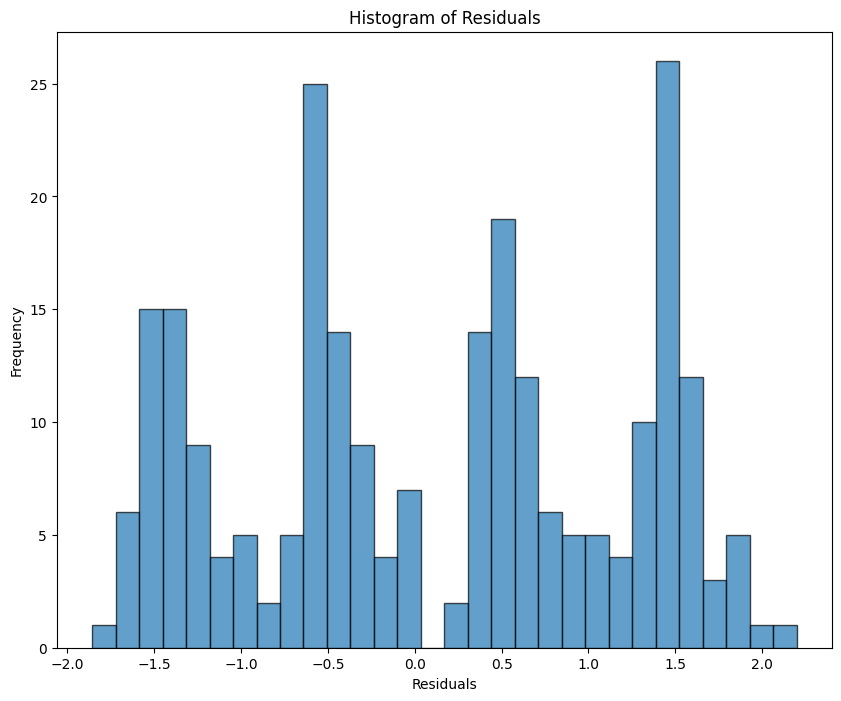

In [25]:
plt.figure(figsize=(10, 8))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


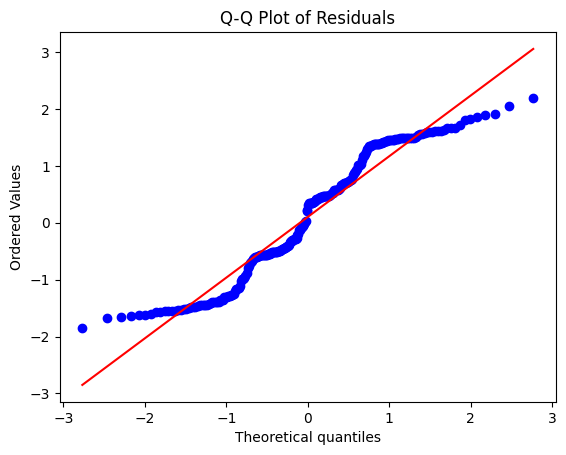

In [26]:
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()


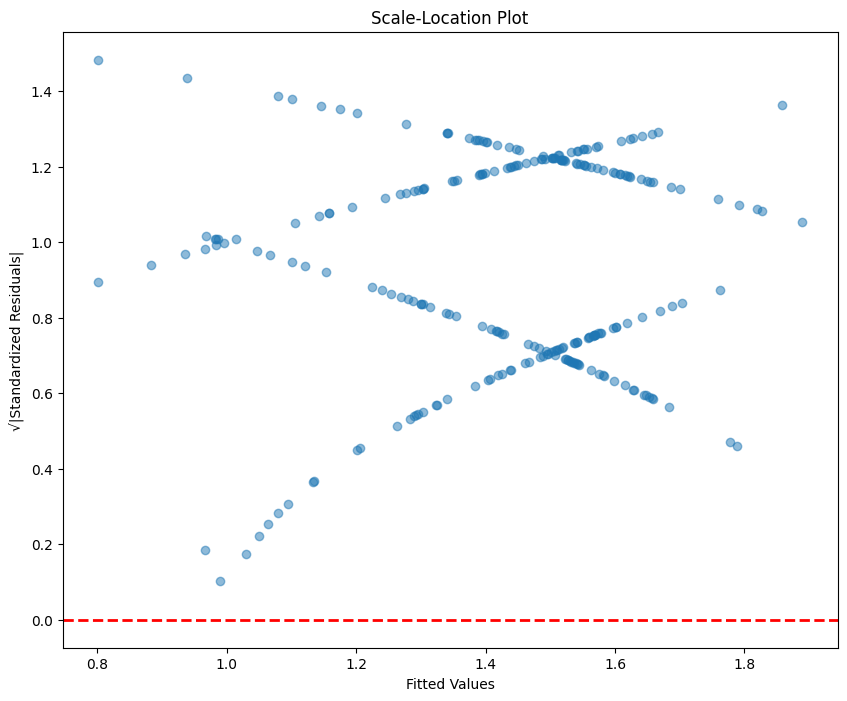

In [27]:
import numpy as np

plt.figure(figsize=(10, 8))
plt.scatter(y_pred, np.sqrt(np.abs(residuals)), alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')
plt.title('Scale-Location Plot')
plt.show()


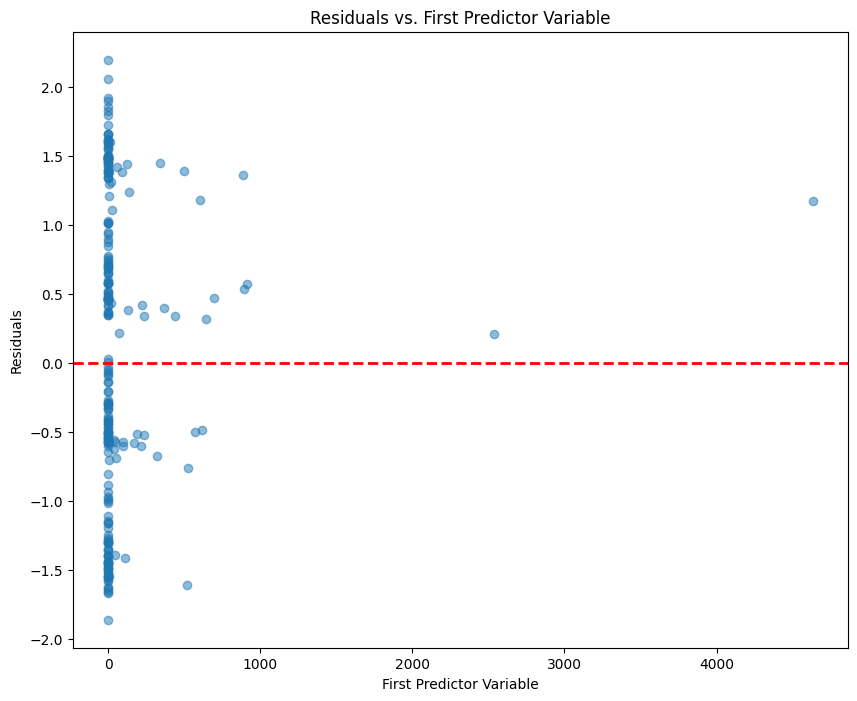

In [28]:
plt.figure(figsize=(10, 8))
plt.scatter(X_agent_test[:, 0], residuals, alpha=0.5)  # Assuming the first predictor variable
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('First Predictor Variable')
plt.ylabel('Residuals')
plt.title('Residuals vs. First Predictor Variable')
plt.show()


## visualization of word embeddings

d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


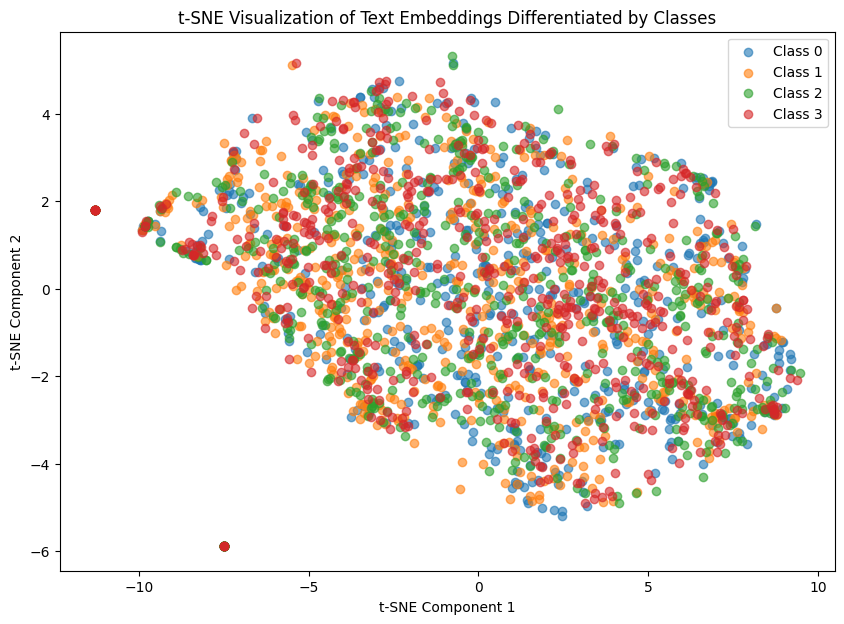

In [29]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Function to extract embeddings for texts
def get_text_embeddings(texts, tokenizer, embedding_matrix, maxlen):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    embeddings = np.zeros((padded_sequences.shape[0], embedding_matrix.shape[1]))

    for i, sequence in enumerate(padded_sequences):
        for word_index in sequence:
            if word_index != 0:
                embeddings[i] += embedding_matrix[word_index]
        embeddings[i] /= (np.count_nonzero(padded_sequences[i]) + 1e-7)  # Avoid division by zero

    return embeddings

# Combine agent and external texts
X_texts = df['clean_agent'].tolist() + df['clean_external'].tolist()
y = np.concatenate([df['impact'].values, df['impact'].values])

# # Tokenize texts and convert to sequences
# tokenizer = Tokenizer(num_words=8897)
# tokenizer.fit_on_texts(X_texts)
# word_index = tokenizer.word_index

# # Load the FastText embeddings
# fasttext_path = 'non-code/embedding/wiki-news-300d-1M-subword.bin/wiki-news-300d-1M-subword.bin'
# fasttext_matrix = load_fasttext_embeddings(fasttext_path, word_index)

# Get embeddings for agent and external texts
maxlen = 500
X_embeddings = get_text_embeddings(X_texts, tokenizer, fasttext_matrix, maxlen)

# Perform t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=0, perplexity=40, n_iter=300)
X_tsne = tsne.fit_transform(X_embeddings)

# Plot the embeddings with different colors for each class
plt.figure(figsize=(10, 7))
for impact_class in np.unique(y):
    indices = np.where(y == impact_class)
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f'Class {impact_class}', alpha=0.6)

plt.title('t-SNE Visualization of Text Embeddings Differentiated by Classes')
plt.legend()
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


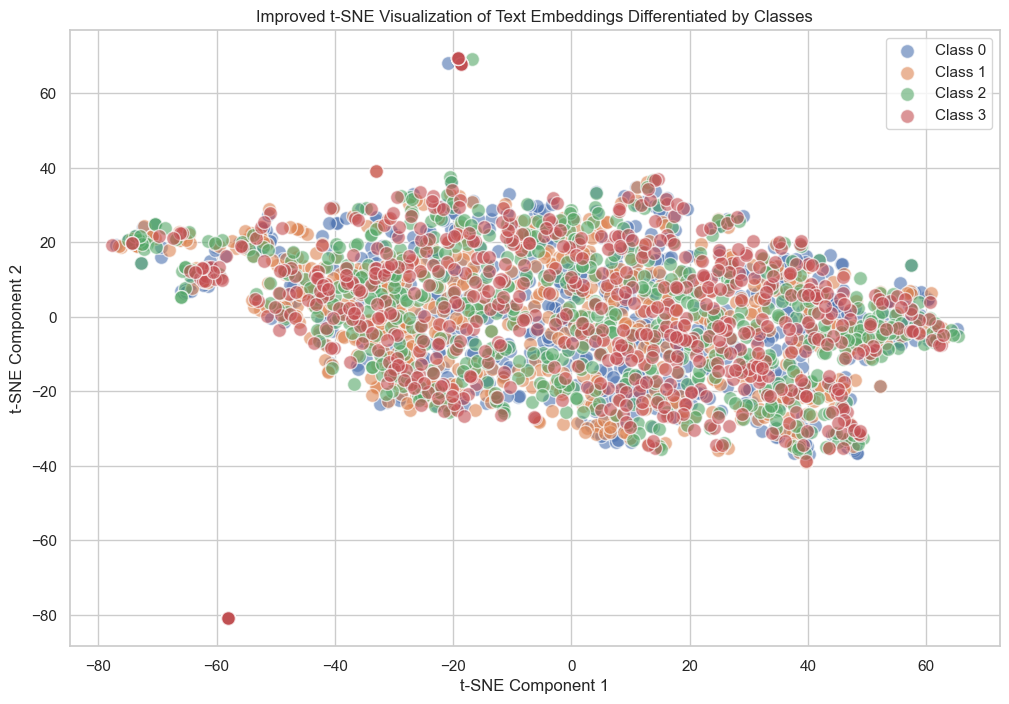

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Function to extract embeddings for texts
def get_text_embeddings(texts, tokenizer, embedding_matrix, maxlen):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    embeddings = np.zeros((padded_sequences.shape[0], embedding_matrix.shape[1]))

    for i, sequence in enumerate(padded_sequences):
        for word_index in sequence:
            if word_index != 0:
                embeddings[i] += embedding_matrix[word_index]
        embeddings[i] /= (np.count_nonzero(padded_sequences[i]) + 1e-7)  # Avoid division by zero

    return embeddings

# Get embeddings for agent and external texts
maxlen = 500
X_embeddings = get_text_embeddings(X_texts, tokenizer, fasttext_matrix, maxlen)

# Perform PCA to reduce dimensionality before t-SNE
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_embeddings)

# Perform t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=200, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# Plot the embeddings with different colors for each class
plt.figure(figsize=(12, 8))
palette = sns.color_palette("hsv", len(np.unique(y)))
for impact_class in np.unique(y):
    indices = np.where(y == impact_class)
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=f'Class {impact_class}', alpha=0.6, marker='o', edgecolors='w', s=100)

plt.title('Improved t-SNE Visualization of Text Embeddings Differentiated by Classes')
plt.legend()
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [31]:
import gensim
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

# Combine agent and external texts
X_texts = df['clean_agent'].tolist() + df['clean_external'].tolist()
y = np.concatenate([df['impact'].values, df['impact'].values])

# Tokenize texts and convert to sequences
tokenizer = Tokenizer(num_words=8897)
tokenizer.fit_on_texts(X_texts)
word_index = tokenizer.word_index

# Load the FastText embeddings
fasttext_path = 'non-code/embedding/wiki-news-300d-1M-subword.bin/wiki-news-300d-1M-subword.bin'
fasttext_matrix = load_fasttext_embeddings(fasttext_path, word_index)


d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


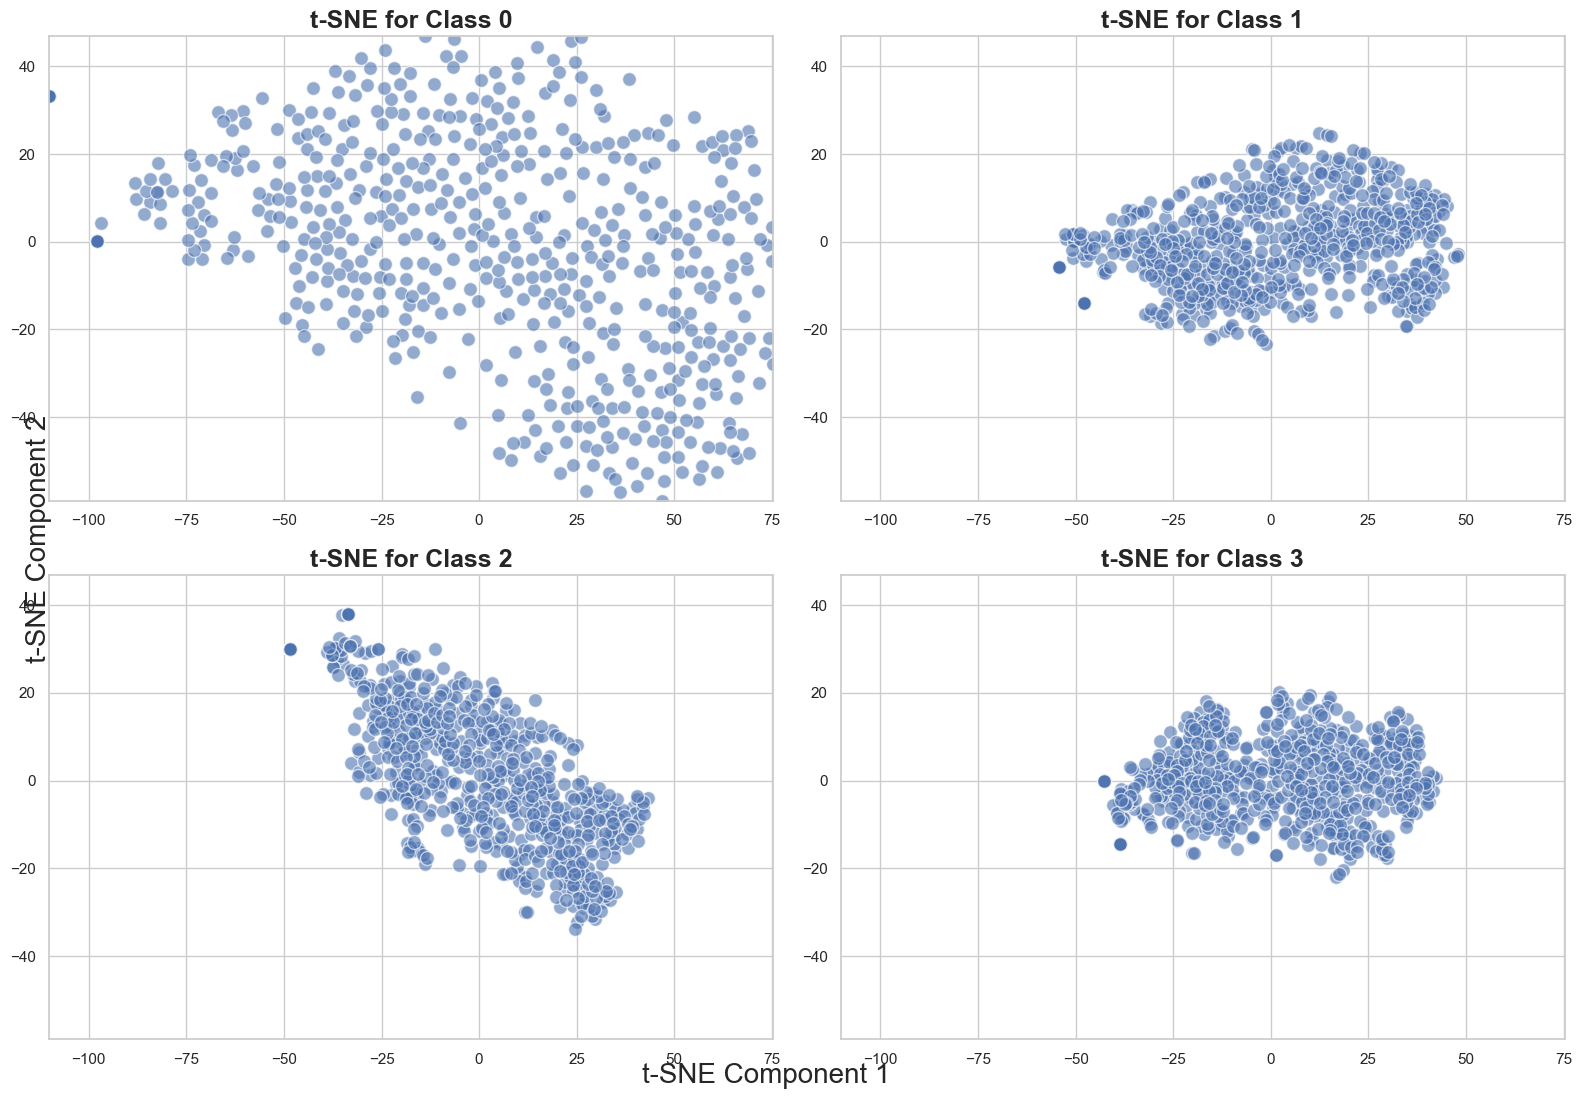

In [32]:
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns

# Function to extract embeddings for texts
def get_text_embeddings(texts, tokenizer, embedding_matrix, maxlen):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    embeddings = np.zeros((padded_sequences.shape[0], embedding_matrix.shape[1]))

    for i, sequence in enumerate(padded_sequences):
        for word_index in sequence:
            if word_index != 0:
                embeddings[i] += embedding_matrix[word_index]
        embeddings[i] /= (np.count_nonzero(padded_sequences[i]) + 1e-7)  # Avoid division by zero

    return embeddings


# Get embeddings for agent and external texts
maxlen = 500
X_embeddings = get_text_embeddings(X_texts, tokenizer, fasttext_matrix, maxlen)

# Perform PCA to reduce dimensionality before t-SNE
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_embeddings)

# Perform t-SNE for Class 0 to determine axis limits
class_0_indices = np.where(y == 0)
X_class_0 = X_pca[class_0_indices]
tsne_class_0 = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=200, n_iter=1000)
X_tsne_class_0 = tsne_class_0.fit_transform(X_class_0)

# Determine the min and max for x and y based on Class 0
x_min, x_max = X_tsne_class_0[:, 0].min(), X_tsne_class_0[:, 0].max()
y_min, y_max = X_tsne_class_0[:, 1].min(), X_tsne_class_0[:, 1].max()

# Create a single plot with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16.54, 11.69))  # A4 size in inches
axes = axes.flatten()

# Set font sizes for readability
plt.rcParams.update({'font.size': 14})

# Plot and save the t-SNE for each class separately with the same scale as Class 0
for i, impact_class in enumerate(np.unique(y)):
    indices = np.where(y == impact_class)
    X_class = X_pca[indices]
    tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=200, n_iter=1000)
    X_tsne_class = tsne.fit_transform(X_class)
    
    ax = axes[i]
    ax.scatter(X_tsne_class[:, 0], X_tsne_class[:, 1], alpha=0.6, marker='o', edgecolors='w', s=100)
    ax.set_title(f't-SNE for Class {impact_class}', fontsize=18, fontweight='bold')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Add common labels
fig.text(0.5, 0.04, 't-SNE Component 1', ha='center', va='center', fontsize=20)
fig.text(0.06, 0.5, 't-SNE Component 2', ha='center', va='center', rotation='vertical', fontsize=20)

# Adjust layout and display the plot
plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])  # Adjust rect to leave space for common labels
plt.show()


In [33]:
import gensim
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd

def load_fasttext_embeddings(file_path, word_index, embedding_dim=300):
    model = gensim.models.fasttext.load_facebook_vectors(file_path)
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in model:
            embedding_matrix[i] = model[word]
    
    return embedding_matrix

# Tokenize texts and convert to sequences
tokenizer = Tokenizer(num_words=8897)
tokenizer.fit_on_texts(X_texts)
word_index = tokenizer.word_index

# Load the FastText embeddings
fasttext_path = 'non-code/embedding/wiki-news-300d-1M-subword.bin/wiki-news-300d-1M-subword.bin'
fasttext_matrix = load_fasttext_embeddings(fasttext_path, word_index)

d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


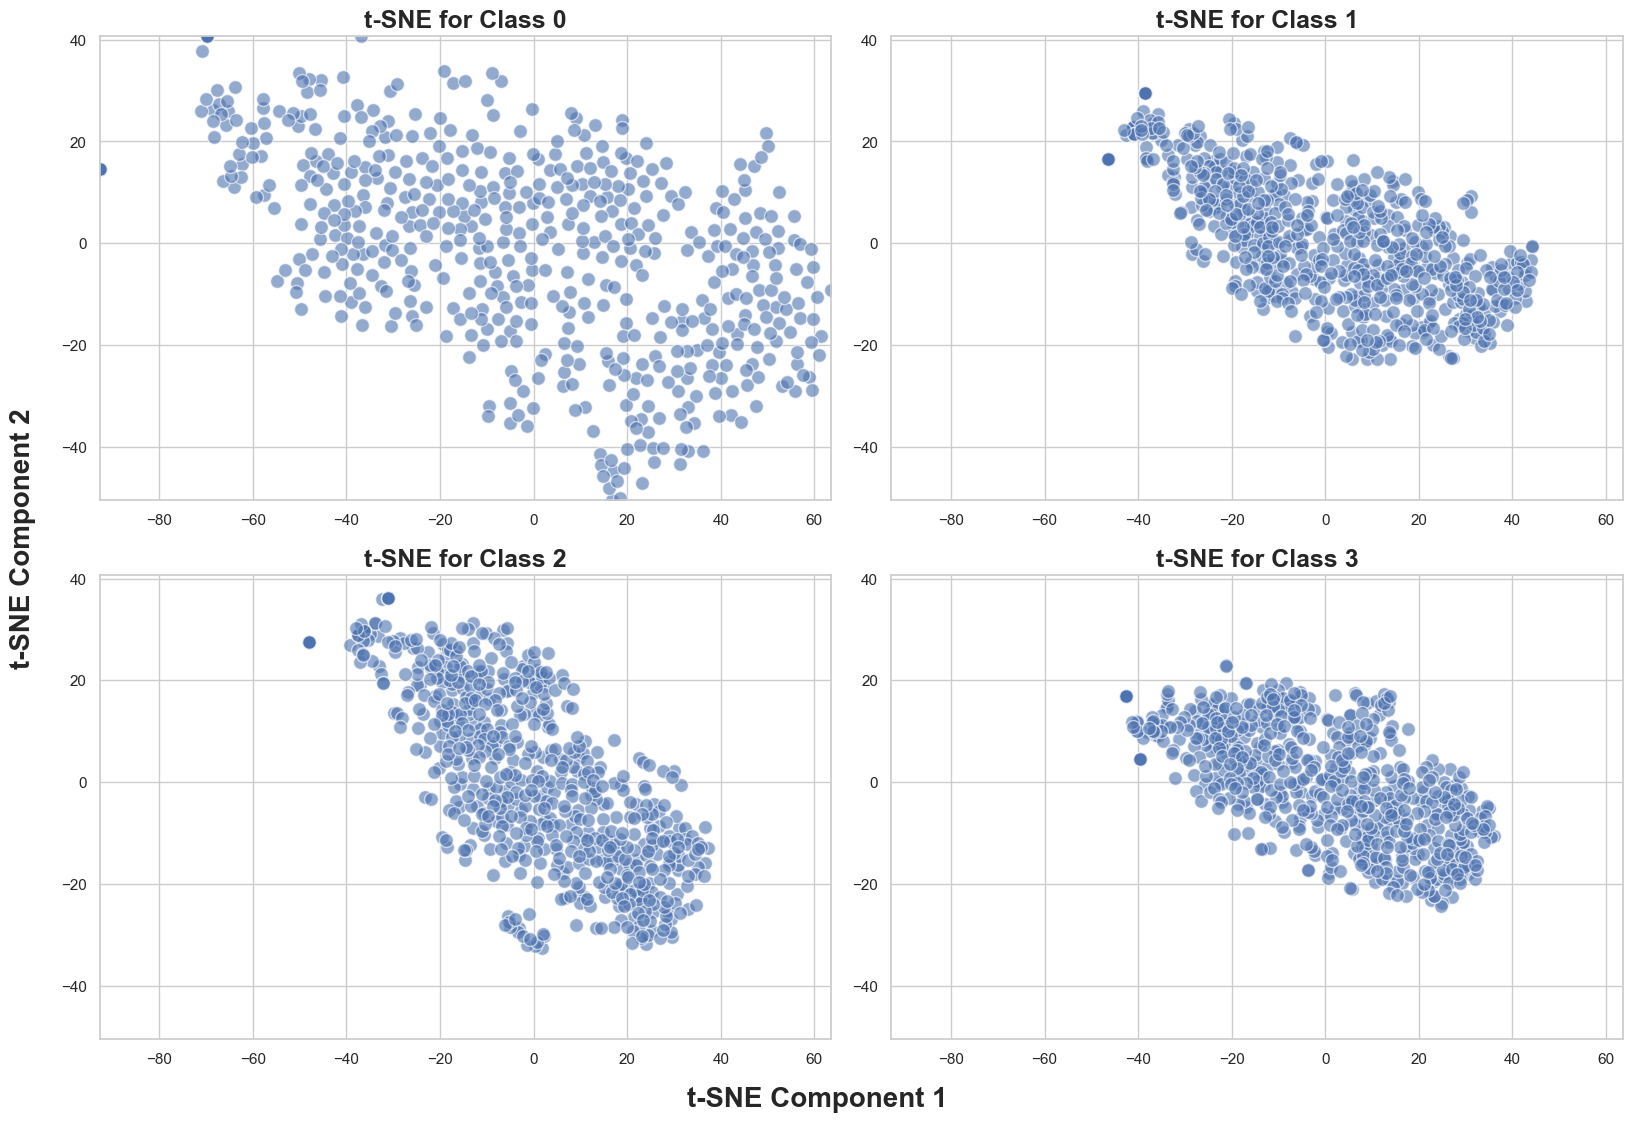

In [34]:
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns

# Function to extract embeddings for texts
def get_text_embeddings(texts, tokenizer, embedding_matrix, maxlen):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    embeddings = np.zeros((padded_sequences.shape[0], embedding_matrix.shape[1]))

    for i, sequence in enumerate(padded_sequences):
        for word_index in sequence:
            if word_index != 0:
                embeddings[i] += embedding_matrix[word_index]
        embeddings[i] /= (np.count_nonzero(padded_sequences[i]) + 1e-7)  # Avoid division by zero

    return embeddings

# Combine agent and external texts
X_texts = df['clean_agent'].tolist() + df['clean_external'].tolist()
y = np.concatenate([df['impact'].values, df['impact'].values])

# # Tokenize texts and convert to sequences
# tokenizer = Tokenizer(num_words=8897)
# tokenizer.fit_on_texts(X_texts)
# word_index = tokenizer.word_index

# Assuming fasttext_matrix is already loaded from previous steps
# fasttext_matrix = load_fasttext_embeddings(fasttext_path, word_index)

# Get embeddings for agent and external texts
maxlen = 500
X_embeddings = get_text_embeddings(X_texts, tokenizer, fasttext_matrix, maxlen)

# Perform PCA to reduce dimensionality before t-SNE
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_embeddings)

# Perform t-SNE for Class 0 to determine axis limits
class_0_indices = np.where(y == 0)
X_class_0 = X_pca[class_0_indices]
tsne_class_0 = TSNE(n_components=2, random_state=59, perplexity=30, learning_rate=200, n_iter=1000)
X_tsne_class_0 = tsne_class_0.fit_transform(X_class_0)

# Determine the min and max for x and y based on Class 0
x_min, x_max = X_tsne_class_0[:, 0].min(), X_tsne_class_0[:, 0].max()
y_min, y_max = X_tsne_class_0[:, 1].min(), X_tsne_class_0[:, 1].max()

# Create a single plot with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(16.54, 11.69))  # A4 size in inches
axes = axes.flatten()

# Set font sizes for readability
plt.rcParams.update({'font.size': 14})

# Plot and save the t-SNE for each class separately with the same scale as Class 0
for i, impact_class in enumerate(np.unique(y)):
    indices = np.where(y == impact_class)
    X_class = X_pca[indices]
    tsne = TSNE(n_components=2, random_state=0, perplexity=30, learning_rate=200, n_iter=1000)
    X_tsne_class = tsne.fit_transform(X_class)
    
    ax = axes[i]
    ax.scatter(X_tsne_class[:, 0], X_tsne_class[:, 1], alpha=0.6, marker='o', edgecolors='w', s=100)
    ax.set_title(f't-SNE for Class {impact_class}', fontsize=18, fontweight='bold')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

# Add common labels
fig.text(0.5, 0.02, 't-SNE Component 1', ha='center', va='center', fontsize=20, fontweight='bold')
fig.text(0.02, 0.5, 't-SNE Component 2', ha='center', va='center', rotation='vertical', fontsize=20, fontweight='bold')

# Adjust layout and display the plot
plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])  # Adjust rect to leave space for common labels
plt.show()


d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


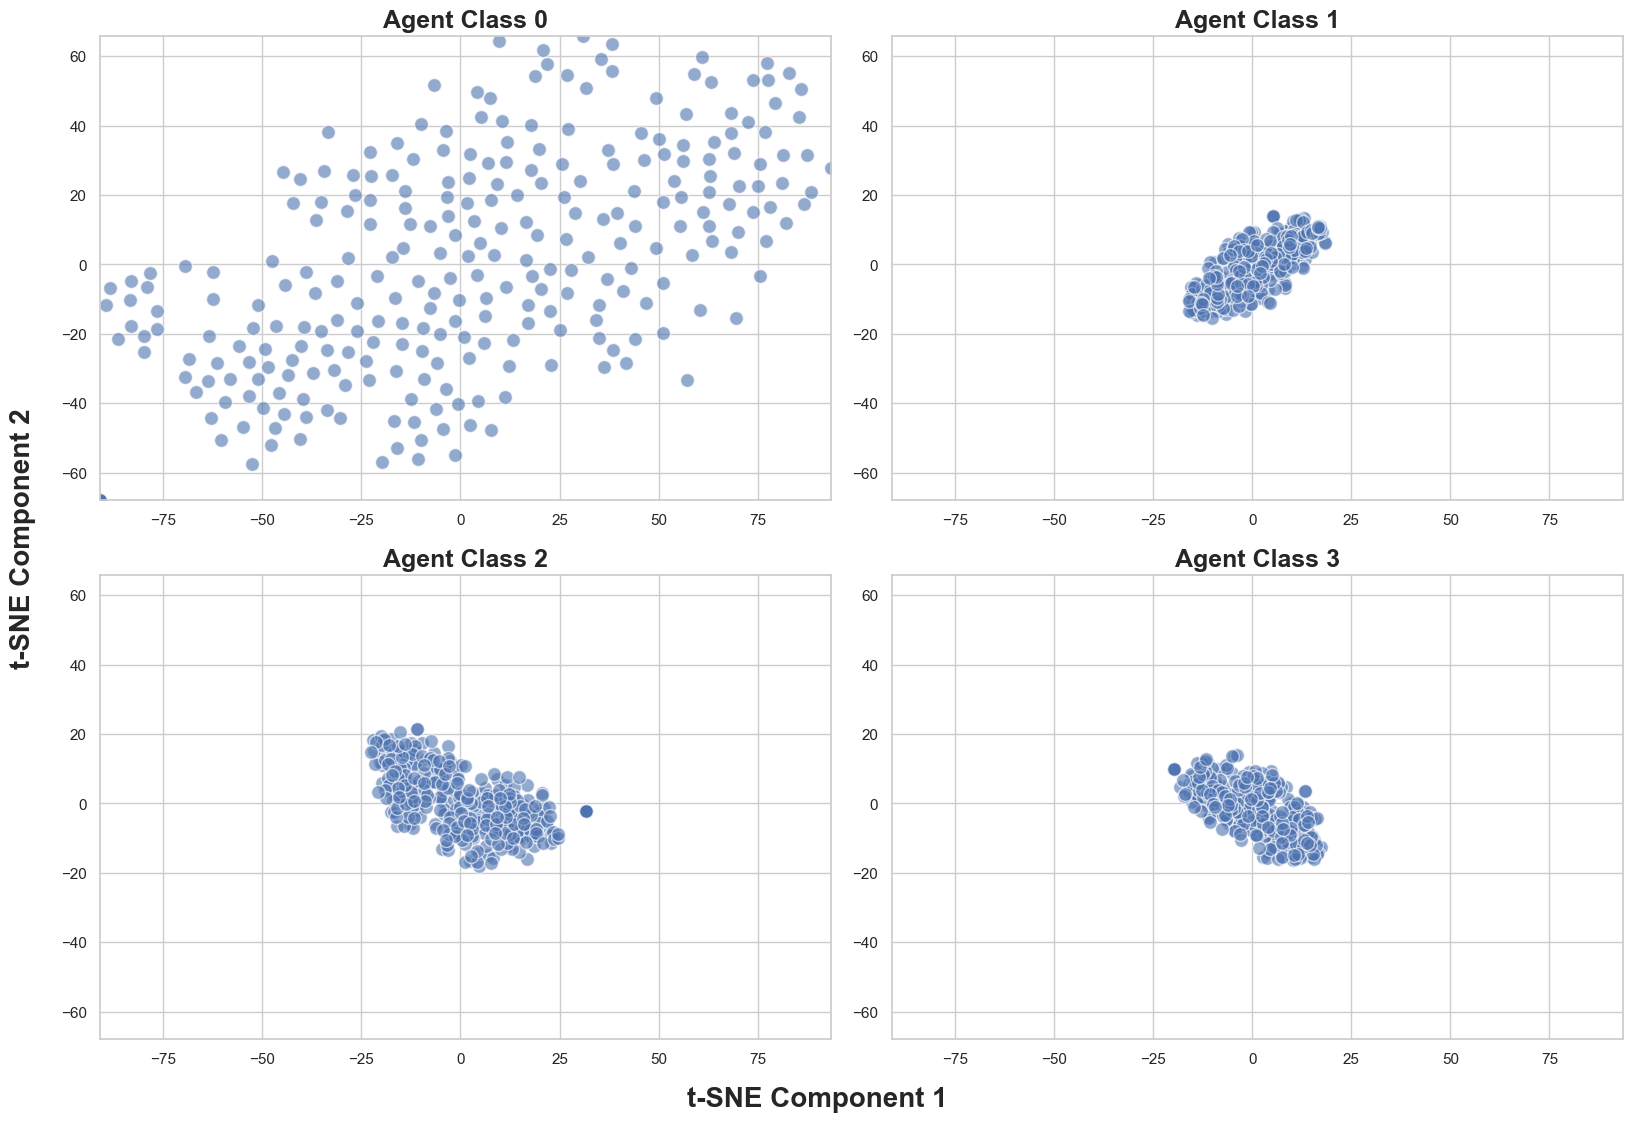

d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
d:\thesis\LATEST\code_3\scriptie_resit\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


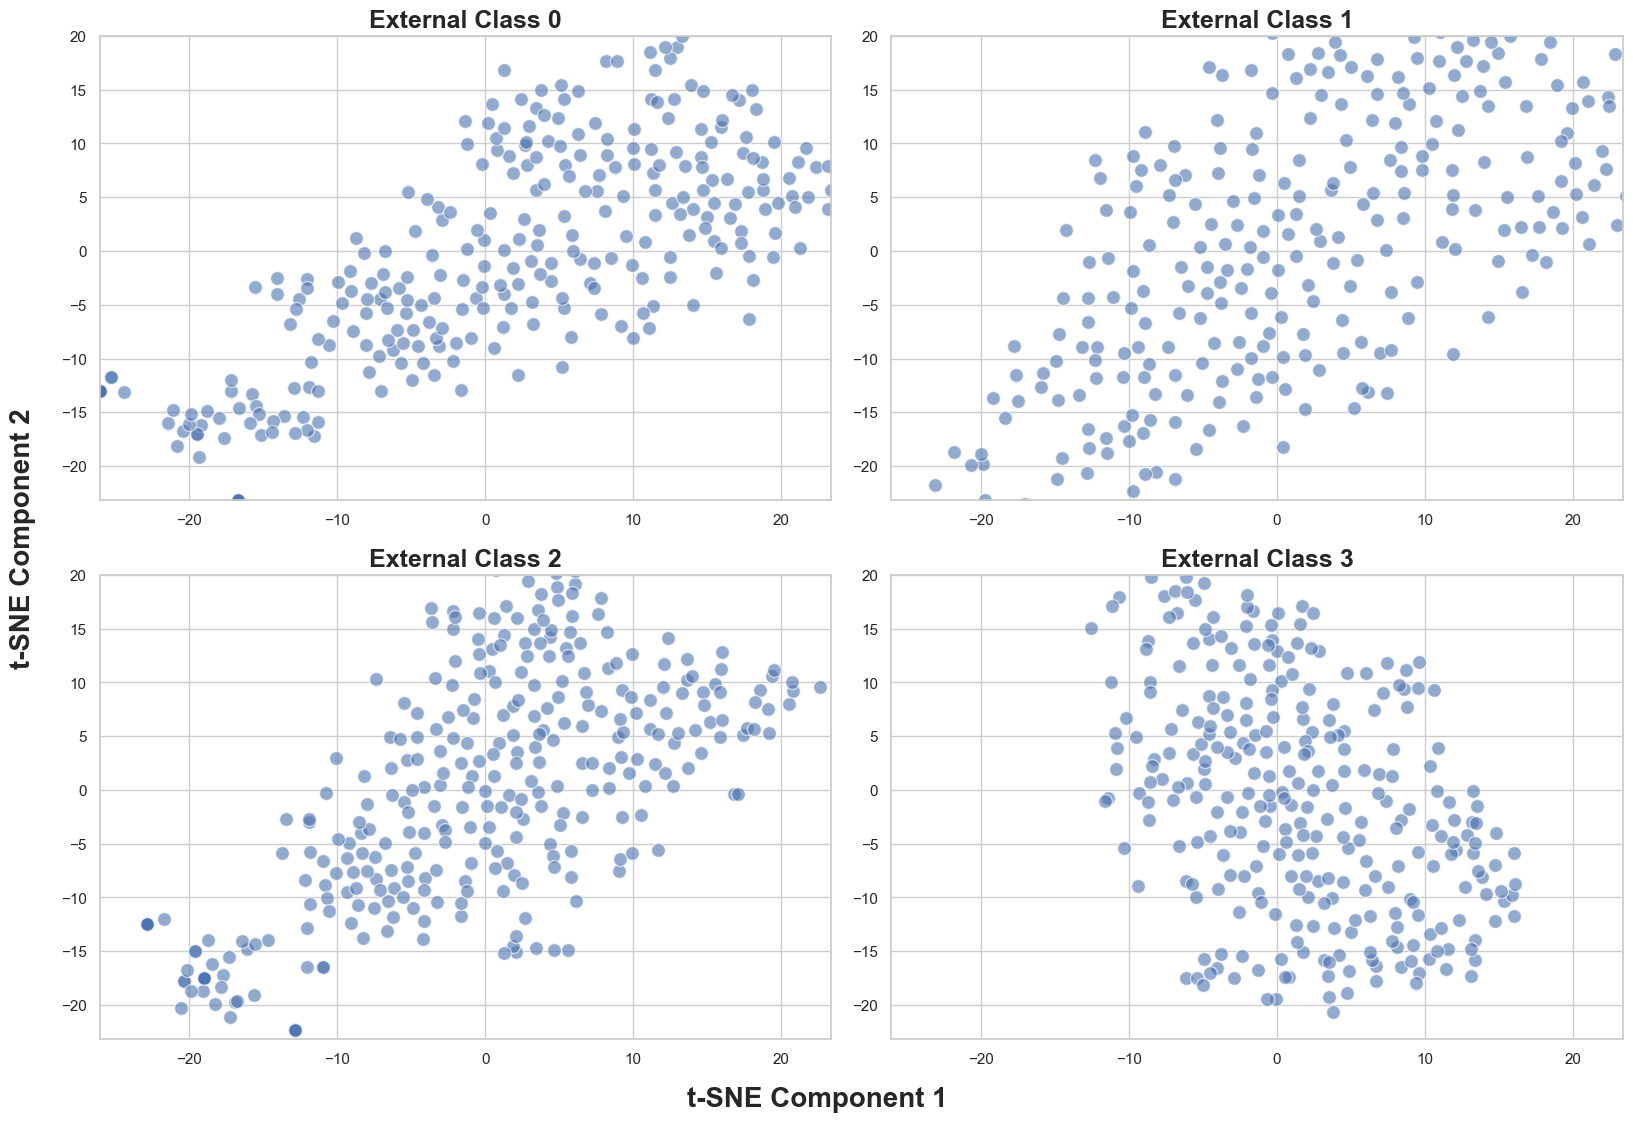

In [35]:
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Function to extract embeddings for texts
def get_text_embeddings(texts, tokenizer, embedding_matrix, maxlen):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen)
    embeddings = np.zeros((padded_sequences.shape[0], embedding_matrix.shape[1]))

    for i, sequence in enumerate(padded_sequences):
        for word_index in sequence:
            if word_index != 0:
                embeddings[i] += embedding_matrix[word_index]
        embeddings[i] /= (np.count_nonzero(padded_sequences[i]) + 1e-7)  # Avoid division by zero

    return embeddings

# Combine agent and external texts
agent_texts = df['clean_agent'].tolist()
external_texts = df['clean_external'].tolist()
y = df['impact'].values

# Tokenize texts and convert to sequences
tokenizer = Tokenizer(num_words=8897)
tokenizer.fit_on_texts(agent_texts + external_texts)
word_index = tokenizer.word_index

# Assuming fasttext_matrix is already loaded from previous steps
# fasttext_matrix = load_fasttext_embeddings(fasttext_path, word_index)

# Get embeddings for agent and external texts
maxlen = 500
agent_embeddings = get_text_embeddings(agent_texts, tokenizer, fasttext_matrix, maxlen)
external_embeddings = get_text_embeddings(external_texts, tokenizer, fasttext_matrix, maxlen)

# Perform PCA to reduce dimensionality before t-SNE
pca = PCA(n_components=50, random_state=0)
agent_pca = pca.fit_transform(agent_embeddings)
external_pca = pca.fit_transform(external_embeddings)

# Define a function to plot t-SNE for a given set of embeddings and labels
def plot_tsne(embeddings, labels, title_prefix, output_file_prefix):
    fig, axes = plt.subplots(2, 2, figsize=(16.54, 11.69))  # A4 size in inches
    axes = axes.flatten()

    plt.rcParams.update({'font.size': 14})

    class_0_indices = np.where(labels == 0)
    X_class_0 = embeddings[class_0_indices]
    tsne_class_0 = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=1000)
    X_tsne_class_0 = tsne_class_0.fit_transform(X_class_0)

    x_min, x_max = X_tsne_class_0[:, 0].min(), X_tsne_class_0[:, 0].max()
    y_min, y_max = X_tsne_class_0[:, 1].min(), X_tsne_class_0[:, 1].max()

    for i, impact_class in enumerate(np.unique(labels)):
        indices = np.where(labels == impact_class)
        X_class = embeddings[indices]
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=1000)
        X_tsne_class = tsne.fit_transform(X_class)

        ax = axes[i]
        ax.scatter(X_tsne_class[:, 0], X_tsne_class[:, 1], alpha=0.6, marker='o', edgecolors='w', s=100)
        ax.set_title(f'{title_prefix} Class {impact_class}', fontsize=18, fontweight='bold')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    fig.text(0.5, 0.02, 't-SNE Component 1', ha='center', va='center', fontsize=20, fontweight='bold')
    fig.text(0.02, 0.5, 't-SNE Component 2', ha='center', va='center', rotation='vertical', fontsize=20, fontweight='bold')

    plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])  # Adjust rect to leave space for common labels
    plt.savefig(f'{output_file_prefix}_tsne.png', dpi=300)
    plt.show()

# Plot t-SNE for agent texts
plot_tsne(agent_pca, y, 'Agent', 'agent')

# Plot t-SNE for external texts
plot_tsne(external_pca, y, 'External', 'external')


C:\Users\flori\AppData\Local\Temp\ipykernel_13132\4120763389.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['impact'] == impact_class]['agent_length'], label='Agent', shade=True, ax=axes[i])
C:\Users\flori\AppData\Local\Temp\ipykernel_13132\4120763389.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['impact'] == impact_class]['external_length'], label='External', shade=True, ax=axes[i])
C:\Users\flori\AppData\Local\Temp\ipykernel_13132\4120763389.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['impact'] == impact_class]['agent_length'], label='Agent', shade=True, ax=axes[i])
C:\Users\flor

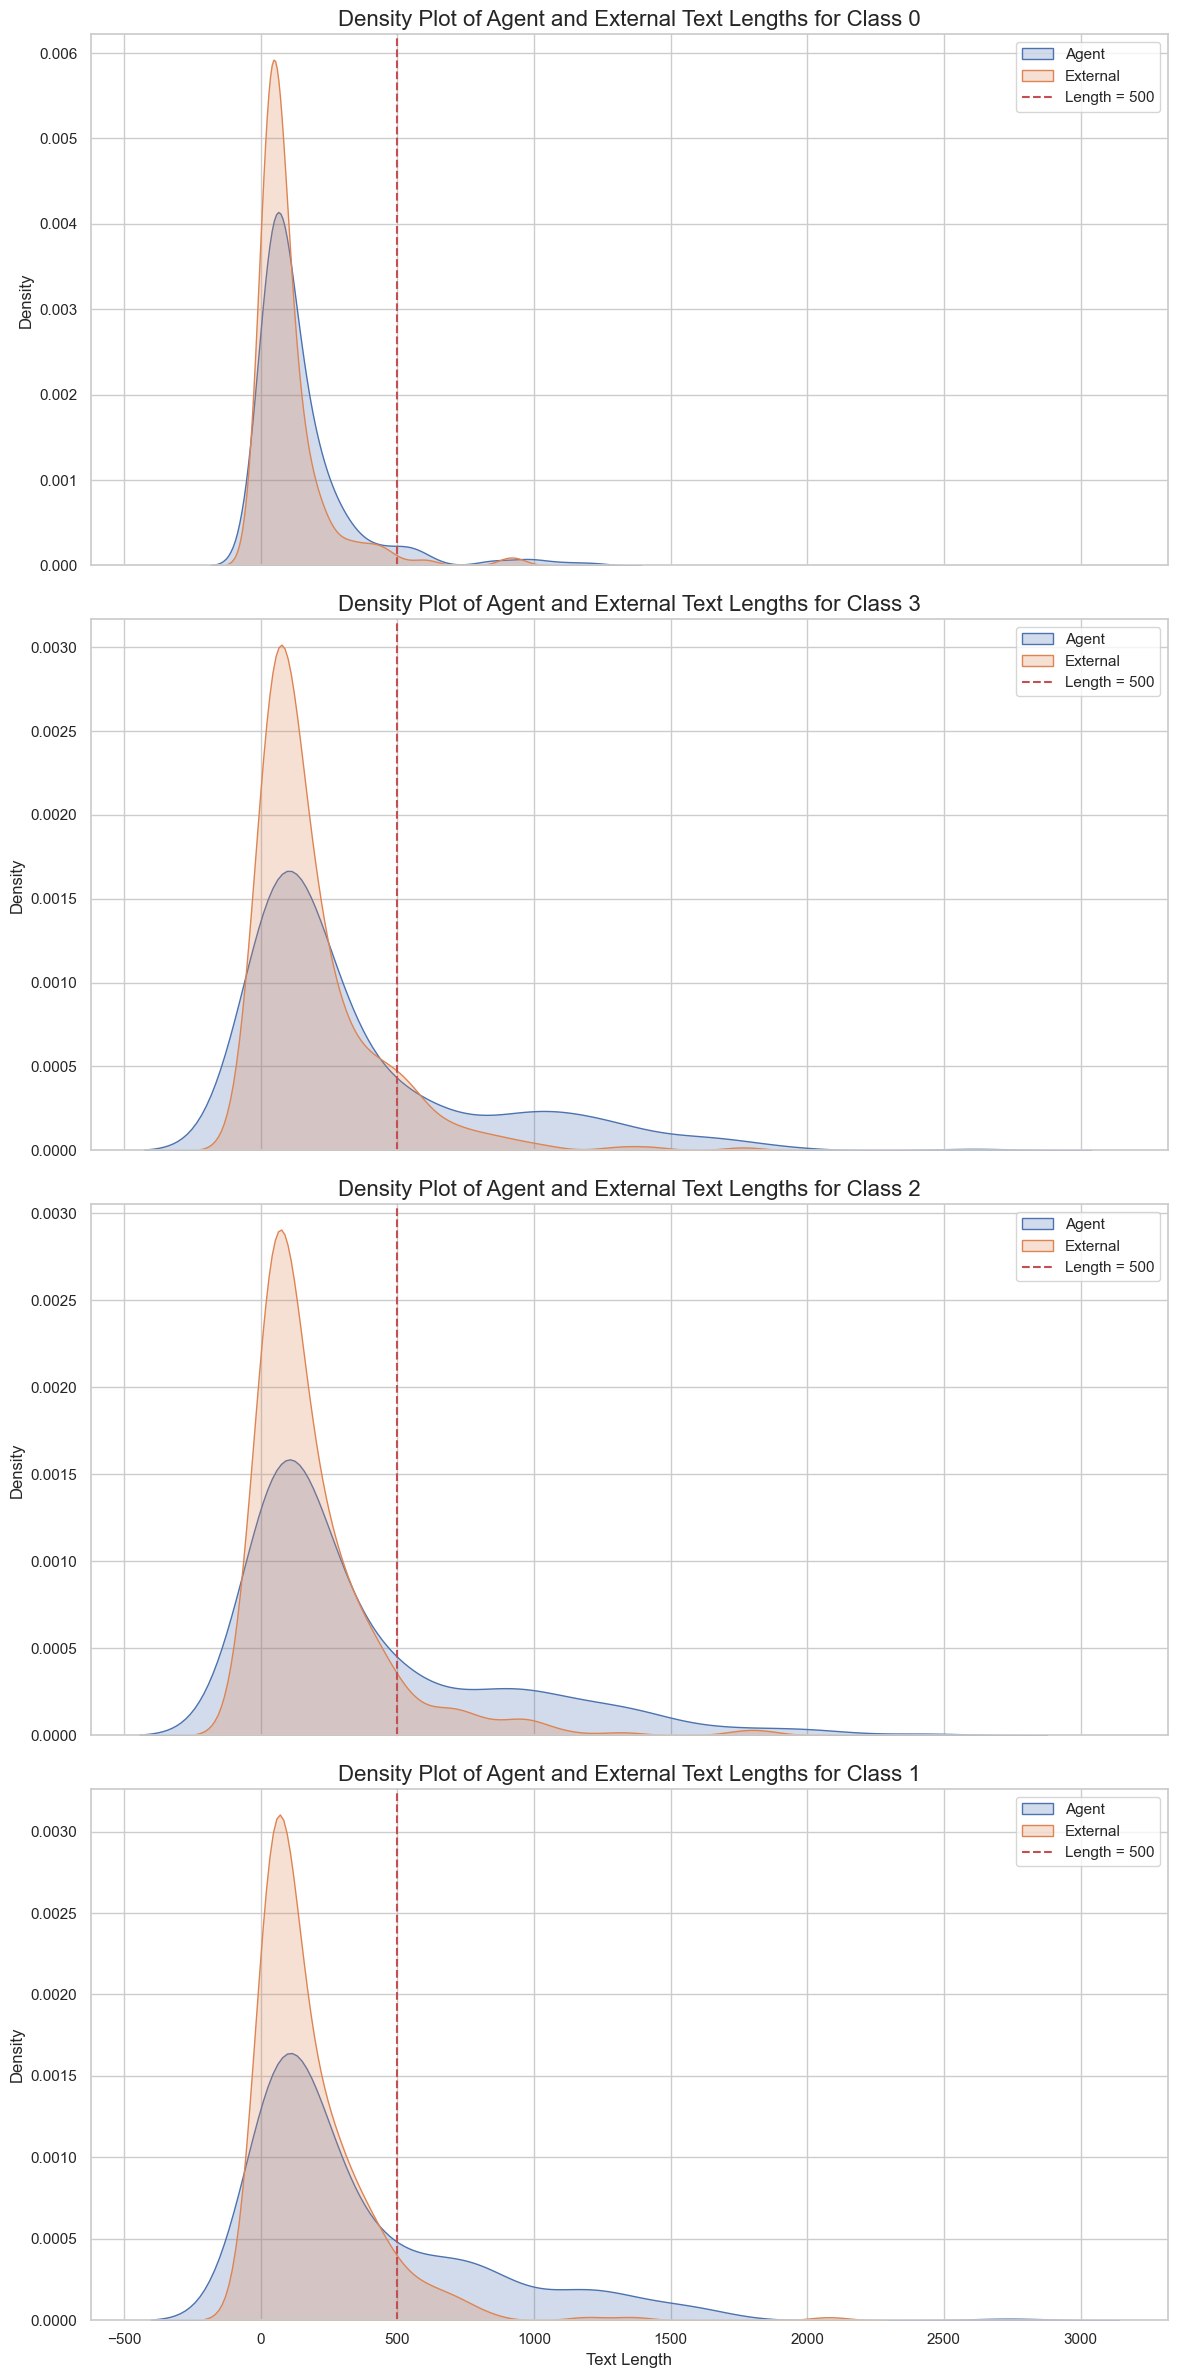

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate the lengths of the agent and external sequences
df['agent_length'] = df['clean_agent'].apply(lambda x: len(x.split()))
df['external_length'] = df['clean_external'].apply(lambda x: len(x.split()))

# Remove any non-positive lengths
df = df[(df['agent_length'] > 0) & (df['external_length'] > 0)]

# Set up the matplotlib figure
fig, axes = plt.subplots(len(df['impact'].unique()), 1, figsize=(12, 6 * len(df['impact'].unique())), sharex=True)

# Create density plots per outcome class
for i, impact_class in enumerate(df['impact'].unique()):
    sns.kdeplot(df[df['impact'] == impact_class]['agent_length'], label='Agent', shade=True, ax=axes[i])
    sns.kdeplot(df[df['impact'] == impact_class]['external_length'], label='External', shade=True, ax=axes[i])

    # Add vertical line at 500
    axes[i].axvline(x=500, color='r', linestyle='--', label='Length = 500')

    # Add titles and labels
    axes[i].set_title(f'Density Plot of Agent and External Text Lengths for Class {impact_class}', fontsize=16)
    axes[i].set_xlabel('Text Length')
    axes[i].set_ylabel('Density')
    axes[i].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


       agent_length  external_length
count   1193.000000      1193.000000
mean     322.108131       174.541492
std      412.501343       220.285683
min        1.000000         1.000000
25%       59.000000        44.000000
50%      138.000000        91.000000
75%      413.000000       229.000000
max     2738.000000      2080.000000


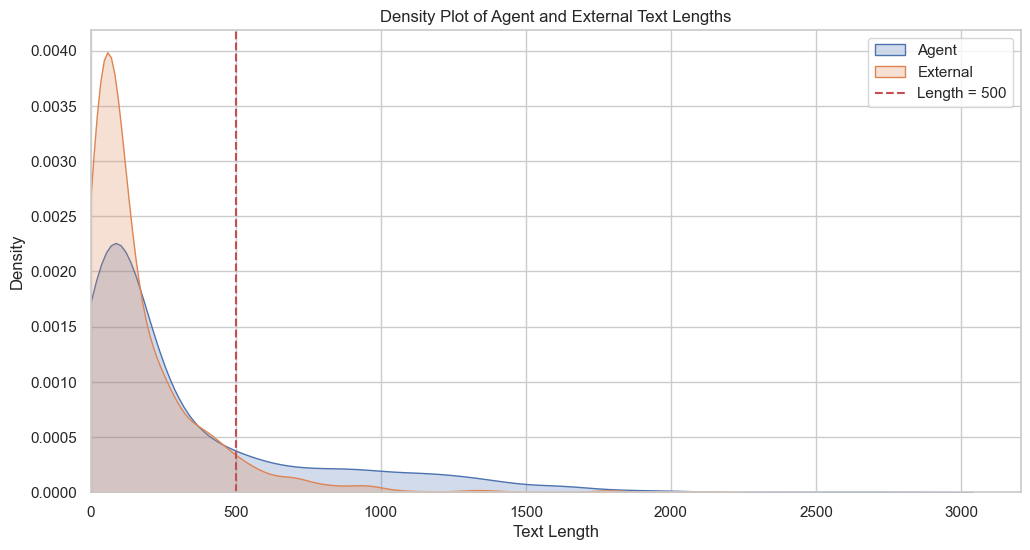

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the lengths are computed correctly
df['agent_length'] = df['clean_agent'].apply(lambda x: len(x.split()))
df['external_length'] = df['clean_external'].apply(lambda x: len(x.split()))

# Check for any negative or zero lengths
negative_lengths = df[(df['agent_length'] <= 0) | (df['external_length'] <= 0)]
if not negative_lengths.empty:
    print("Found negative or zero lengths:")
    print(negative_lengths)

# Remove any non-positive lengths
df = df[(df['agent_length'] > 0) & (df['external_length'] > 0)]

# Ensure no negative values are left
print(df[['agent_length', 'external_length']].describe())

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot density plots
sns.kdeplot(df['agent_length'], label='Agent', fill=True)
sns.kdeplot(df['external_length'], label='External', fill=True)

# Add vertical line at 500
plt.axvline(x=500, color='r', linestyle='--', label='Length = 500')

# Add titles and labels
plt.title('Density Plot of Agent and External Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Density')
plt.legend()

# Set x-axis limit to ensure no sub-zero values are displayed
plt.xlim(left=0)

# Show the plot
plt.show()


In [38]:
import pandas as pd

# Calculate the lengths of the agent and external sequences
df['agent_length'] = df['clean_agent'].apply(lambda x: len(x.split()))
df['external_length'] = df['clean_external'].apply(lambda x: len(x.split()))

# Remove any non-positive lengths
df = df[(df['agent_length'] > 0) & (df['external_length'] > 0)]

# Calculate the percentage of samples with sequence length below 500
agent_below_500 = (df['agent_length'] < 500).mean() * 100
external_below_500 = (df['external_length'] < 500).mean() * 100

print(f"Percentage of agent sequences below 500: {agent_below_500:.2f}%")
print(f"Percentage of external sequences below 500: {external_below_500:.2f}%")


Percentage of agent sequences below 500: 78.71%
Percentage of external sequences below 500: 93.04%
